In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import seaborn as sns   
from scipy.stats import chi2_contingency
import csv

# Data Analysis: this is the version with extra steps, outside of what's needed for the revisions
Analyze the processed data from CLEAN-Contact, CLEAN, and BioCyc. See /case-study/analysis/notebooks/data_processing.ipynb for details on how the data was processed.

CLEAN-Contact
* both .csvs with CLEAN-Contact results have 1939 rows and UniProt Ids
    * cc_maxsep_results_full.csv
    * cc_pvalue_results_full.csv
* this notebook analyzes the maxsep inference method results, which includes confidence scores

CLEAN 
* results .csv has 1942 rows and UniProt ids
    * clean_combined_results_full.csv
* this notebook analyzes the maxsep inference method results, which includes confidence scores, since the CLEAN results for the pvalue inference method doesn't have confidence scores

BioCyc 
* Prochlorococcus marinus subsp. pastoris str. CCMP1986, also known as MED4, data pulled from BioCyc
* this dataset has 728 rows. Of those, 684 have both a Uniprot id and an EC number
    * biocyc_updated.csv

The CLEAN-Contact results had 1939 ids not 1942 like the CLEAN results because we didn't have the protein structures for 3 of the proteins.

In [2]:
def list_of_unique_ecs(df, colname):
    # using a set guarantees elements in the list will be unique
    # EC numbers containing 'n' are also seen as unique
    unique_ec_values = set()

    for entry in df[colname]:
        # skip the NaN values
        if pd.isna(entry):
            continue
        ec_list = entry.split(', ')
        # update the set with the split values
        unique_ec_values.update(ec_list)

    # convert the set back to a sorted list
    unique_ec_values_list = sorted(unique_ec_values)
    return unique_ec_values_list

def calculate_subsets(list1, list2, list3):
    # inputs are lists, outputs are sets
    set1 = set(list1)
    set2 = set(list2)
    set3 = set(list3)
    # calculate subsets of the EC numbers found in each dataset
    only_set1 = set1 - (set2 | set3)
    only_set2 = set2 - (set1 | set3)
    only_set3 = set3 - (set1 | set2)

    set1_and_set2 = (set1 & set2) - set3
    set1_and_set3 = (set1 & set3) - set2
    set2_and_set3 = (set2 & set3) - set1

    all_three = set1 & set2 & set3
    return only_set1, only_set2, only_set3, set1_and_set2, set1_and_set3, set2_and_set3, all_three

def separate_sets_by_number_of_ec_digits(ec_set):
    # input one of the ec number sets
    # output dict containing subsets, with different lengths of digits in the ec numbers
    length_counts = {}
    length_subsets = {}

    # categorize, count, and subset
    for ec in ec_set:
        # split by '.' after removing the 'EC:'
        parts = ec[3:].split('.')
        length = len(parts)

        # initialize dictionary entries if not already present
        if length not in length_counts:
            length_counts[length] = 0
            length_subsets[length] = set()

        # increment count
        length_counts[length] += 1
        # add to appropriate subset
        length_subsets[length].add(ec)
    return length_subsets

def subset_ec_by_first_digit(ec_set):
    starting_number_subsets = {}

    # Categorize based on the first number
    for ec in ec_set:
        # Extract the first number after 'EC:'
        first_number = ec.split(':')[1].split('.')[0]

        # Initialize the dictionary entry if not already present
        if first_number not in starting_number_subsets:
            starting_number_subsets[first_number] = set()

        # Add the EC number to the appropriate subset
        starting_number_subsets[first_number].add(ec)
    return starting_number_subsets

def visualize_first_digits_distribution(ec_set, plot_title, use_percentage=False):
    # visualize one set
    class_names = {
        '1': 'Oxidoreductases',
        '2': 'Transferases',
        '3': 'Hydrolases',
        '4': 'Lyases',
        '5': 'Isomerases',
        '6': 'Ligases',
        '7': 'Translocases'}

    starting_number_subsets = subset_ec_by_first_digit(ec_set)
    sorted_keys = sorted(starting_number_subsets.keys(), key=int)
    
    # for calculating percentages
    total_ec_numbers = len(ec_set)
    percentages = [len(starting_number_subsets[key]) / total_ec_numbers * 100 for key in sorted_keys]
    
    # visualization
    labels = [f'{key}: {class_names.get(key, "Unknown Class")}' for key in sorted_keys]
    counts = [len(starting_number_subsets[key]) for key in sorted_keys]

    plt.figure(figsize=(10, 6))
    if use_percentage == False:
        plt.bar(labels, counts)
        plt.xlabel('Top Level EC number')
        plt.ylabel('Count')
        plt.title(plot_title)
        plt.xticks(fontsize=9) 
        plt.tight_layout() 
        plt.show()
    else:
        plt.bar(labels, percentages)
        plt.xlabel('Top Level EC number')
        plt.ylabel('Percentage (%)')
        plt.title(plot_title)
        plt.xticks(fontsize=9)  
        plt.tight_layout() 
        plt.show()   
        
def get_counts(ec_set):
    starting_number_subsets = subset_ec_by_first_digit(ec_set)
    sorted_keys = sorted(starting_number_subsets.keys(), key=int)
    counts = [len(starting_number_subsets[key]) for key in sorted_keys]
    return sorted_keys, counts

def visualize_combined_distributions(ec_sets, plot_title, dataset_labels, use_percent=False):
    # visualze three sets in one visual
    class_names = {
        '1': 'Oxidoreductases',
        '2': 'Transferases',
        '3': 'Hydrolases',
        '4': 'Lyases',
        '5': 'Isomerases',
        '6': 'Ligases',
        '7': 'Translocases'}

    all_keys = set()
    counts_per_set = []
    percentages_per_set = []

    # get counts for all sets and collect all unique keys
    for ec_set in ec_sets:
        keys, counts = get_counts(ec_set)
        total = sum(counts)
        percentages = [(count / total * 100) for count in counts]
        all_keys.update(keys)
        counts_per_set.append(dict(zip(keys, counts)))
        percentages_per_set.append(dict(zip(keys, percentages)))

    combined_keys = sorted(all_keys, key=int)

    combined_counts = []
    for counts_dict in counts_per_set:
        combined_counts.append([counts_dict.get(key, 0) for key in combined_keys])
    
    combined_percentages = []
    for percentages_dict in percentages_per_set:
        combined_percentages.append([percentages_dict.get(key, 0.0) for key in combined_keys])

    # bar width
    num_datasets = len(ec_sets)
    bar_width = 0.8 / num_datasets  # adjust width based on number of datasets

    x = np.arange(len(combined_keys))
    fig, ax = plt.subplots(figsize=(12, 7))
    sns_colors = sns.color_palette("colorblind", num_datasets)
    
    if use_percent == False:
        for i, counts in enumerate(combined_counts):
            ax.bar(x + i * bar_width - bar_width*(num_datasets-1)/2, counts, bar_width, 
                   label=dataset_labels[i], color=sns_colors[i])

        # labels for top-level EC numbers
        labels = [f'{key}: {class_names.get(key, "Unknown Class")}' for key in combined_keys]
        ax.set_xlabel('Top Level EC number')
        ax.set_ylabel('Count')
        ax.set_title(plot_title)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        plt.xticks(fontsize=11) 
        plt.tight_layout()
        plt.show()
    else:
        for i, percentages in enumerate(combined_percentages):
            ax.bar(x + i * bar_width - bar_width*(num_datasets-1)/2, percentages, bar_width, 
                   label=custom_labels[i], color=sns_colors[i])

        labels = [f'{key}: {class_names.get(key, "Unknown Class")}' for key in combined_keys]
        ax.set_xlabel('Top Level EC number')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(plot_title)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        plt.xticks(fontsize=11) 
        plt.tight_layout()
        plt.show()

### Look at all unique EC numbers in each of the 3 datasets, by top level EC number



In [3]:
# CLEAN-Contact dataset
cc_maxsep = pd.read_csv('cc_maxsep_results_full.csv')
print("row and col numbers for CLEAN-Contact dataframe:", cc_maxsep.shape)
print("Number of non-NaN values in the 'CC maxsep EC' column:", cc_maxsep['CC maxsep EC'].count())

# list of the unique EC numbers from CLEAN-Contact's maxsep inference method, for all 1939 UniProt ids in that dataset
cc_maxsep_ec_list = list_of_unique_ecs(cc_maxsep, 'CC maxsep EC')
print("unique number of ec numbers in the CLEAN-Contact dataset:", len(cc_maxsep_ec_list)) 

row and col numbers for CLEAN-Contact dataframe: (1939, 7)
Number of non-NaN values in the 'CC maxsep EC' column: 1939
unique number of ec numbers in the CLEAN-Contact dataset: 1054


In [4]:
cc_maxsep

,UniProt,Annotation,Sequence,CC maxsep EC,CC maxsep conf,CC maxsep conf SD,CC maxsep cluster dist
0,Q7TU21,Aspartate-semialdehyde dehydrogenase OS=Prochl...,MRNSPFLPNRPLKVAVLGSSGAVGSELLKILEERDFPISELVLLSS...,EC:1.2.1.11,0.9863,0.0041,4.3332
1,Q7UZH7,CTP synthase OS=Prochlorococcus marinus subsp....,MSKFVFVTGGVVSSIGKGIVAASLGRLLKSRGYSVSILKLDPYLNV...,EC:6.3.4.2,0.9961,0.0017,2.8527
2,Q7UZR6,Bifunctional pantoate ligase/cytidylate kinase...,MNKIIIRKTEDLKEWRRNLKCDINFIPTMGNLHDGHQKLISTAQSS...,EC:6.3.2.1,0.8120,0.0551,5.8351
3,Q7V010,Probable dual-specificity RNA methyltransferas...,MKNLLGCSVKDLEKIALNYGQAAFRGRQIYNWLYNYKNRSKSIDEI...,EC:2.1.1.192,0.9923,0.0025,3.8433
4,Q7V0C4,Circadian clock oscillator protein KaiC OS=Pro...,MKDKKISKSIKMQVQKIPTGIEGFDDVCRGGLPAARSTLVSGTSGT...,EC:2.7.11.1,0.0911,0.0452,7.2259
...,...,...,...,...,...,...,...
1934,Q7V3R0,Antitermination protein NusB OS=Prochlorococcu...,MMHNRSLSRELSLLSLGLIKDTADLELNKIQIDEIFESALDSLINH...,EC:4.2.3.187,0.0014,0.0012,8.4480
1935,Q7V3R1,Transporter OS=Prochlorococcus marinus subsp. ...,MVESTQSQDSNLGTRLQQDLKNDLIAGLLVVIPLATTIWLSSIVSK...,EC:2.7.1.66,0.0014,0.0012,8.4444
1936,Q7V3R2,4Fe-4S ferredoxin-type domain-containing prote...,MRNMIQNKKEFSEKLKKRAIFEGFAVSGIASIPGSSRVKLRTQALE...,EC:1.17.99.6,0.9914,0.0028,3.9525
1937,Q7V3R3,Uncharacterized protein OS=Prochlorococcus mar...,MKKSLLKILFFSIISSHVFIAESLKALIPYYYLPETKSLQKQGLSI...,EC:3.5.2.6,0.0787,0.0403,7.2768


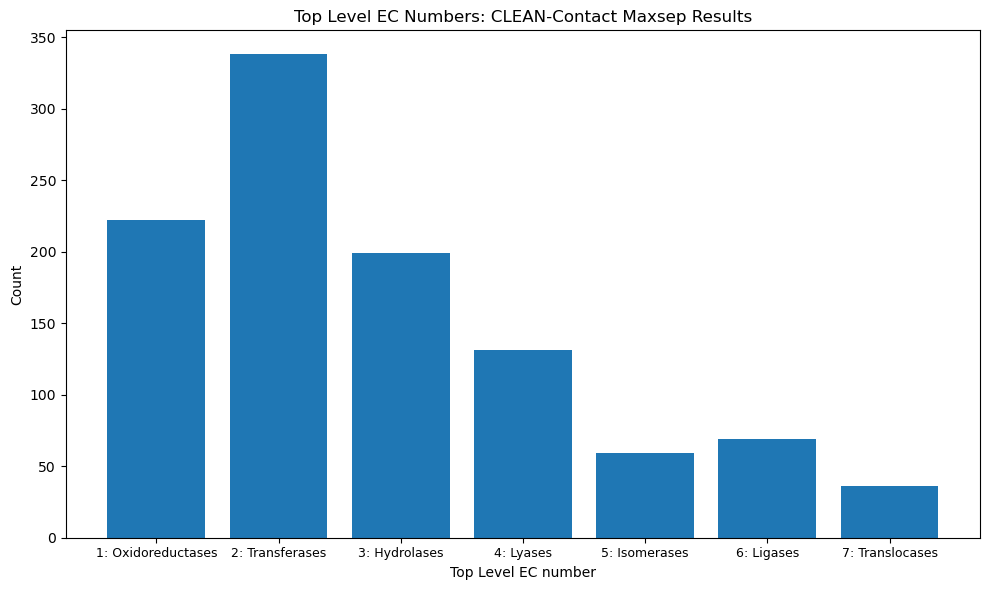

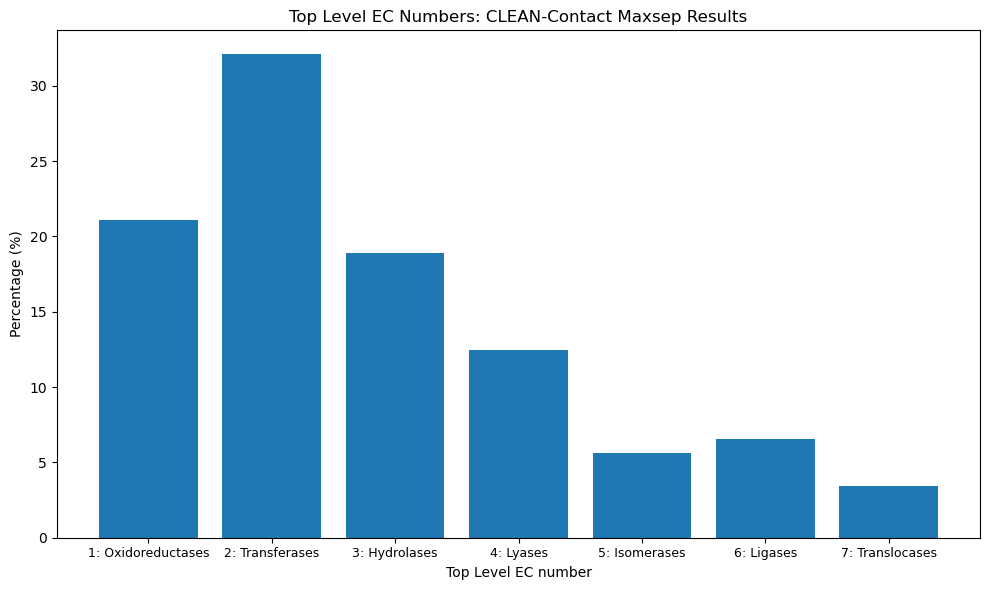

In [5]:
# visualize the unique EC numbers in a dataset by their top level number, using actual counts
visualize_first_digits_distribution(set(cc_maxsep_ec_list), 'Top Level EC Numbers: CLEAN-Contact Maxsep Results')
# include 'True' param to view using percentage of the input set not counts
visualize_first_digits_distribution(set(cc_maxsep_ec_list), 'Top Level EC Numbers: CLEAN-Contact Maxsep Results', True)

In [6]:
# CLEAN dataset
clean_results = pd.read_csv('clean_combined_results_full.csv')
print("row and col numbers for CLEAN dataframe:", clean_results.shape)
print("Number of non-NaN values in the 'Clean maxsep EC' column:", clean_results['Clean maxsep EC'].count())

# list of the unique EC numbers from CLEAN's maxsep inference method, for all 1942 UniProt ids in that dataset
clean_maxsep_ec_list = list_of_unique_ecs(clean_results, 'Clean maxsep EC')
print("unique number of ec numbers in the CLEAN dataset:", len(clean_maxsep_ec_list)) 

row and col numbers for CLEAN dataframe: (1942, 7)
Number of non-NaN values in the 'Clean maxsep EC' column: 1942
unique number of ec numbers in the CLEAN dataset: 1053


In [7]:
clean_results

,UniProt,Annotation,Sequence,Clean maxsep EC,Clean maxsep conf,Clean pvalue EC,Clean pvalue cluster dist
0,Q7TU21,Aspartate-semialdehyde dehydrogenase OS=Prochl...,MRNSPFLPNRPLKVAVLGSSGAVGSELLKILEERDFPISELVLLSS...,EC:1.2.1.11,0.9935,EC:1.2.1.11,3.7585
1,Q7UZH7,CTP synthase OS=Prochlorococcus marinus subsp....,MSKFVFVTGGVVSSIGKGIVAASLGRLLKSRGYSVSILKLDPYLNV...,EC:6.3.4.2,0.9976,EC:6.3.4.2,2.9574
2,Q7UZR6,Bifunctional pantoate ligase/cytidylate kinase...,MNKIIIRKTEDLKEWRRNLKCDINFIPTMGNLHDGHQKLISTAQSS...,EC:2.7.4.25,0.2534,EC:2.7.4.25,6.4352
3,Q7V010,Probable dual-specificity RNA methyltransferas...,MKNLLGCSVKDLEKIALNYGQAAFRGRQIYNWLYNYKNRSKSIDEI...,EC:2.1.1.192,0.9917,"EC:2.1.1.192, EC:2.1.1.224","3.9242, 4.9630"
4,Q7V0C4,Circadian clock oscillator protein KaiC OS=Pro...,MKDKKISKSIKMQVQKIPTGIEGFDDVCRGGLPAARSTLVSGTSGT...,EC:2.7.11.1,0.0451,EC:2.7.11.1,7.0824
...,...,...,...,...,...,...,...
1937,Q7V3R0,Antitermination protein NusB OS=Prochlorococcu...,MMHNRSLSRELSLLSLGLIKDTADLELNKIQIDEIFESALDSLINH...,EC:2.5.1.17,0.0002,EC:2.5.1.17,8.6199
1938,Q7V3R1,Transporter OS=Prochlorococcus marinus subsp. ...,MVESTQSQDSNLGTRLQQDLKNDLIAGLLVVIPLATTIWLSSIVSK...,EC:1.1.5.2,0.0001,EC:1.1.5.2,8.6942
1939,Q7V3R2,4Fe-4S ferredoxin-type domain-containing prote...,MRNMIQNKKEFSEKLKKRAIFEGFAVSGIASIPGSSRVKLRTQALE...,EC:1.17.99.6,0.9886,EC:1.17.99.6,4.1148
1940,Q7V3R3,Uncharacterized protein OS=Prochlorococcus mar...,MKKSLLKILFFSIISSHVFIAESLKALIPYYYLPETKSLQKQGLSI...,EC:5.2.1.8,0.0077,EC:5.2.1.8,7.6222


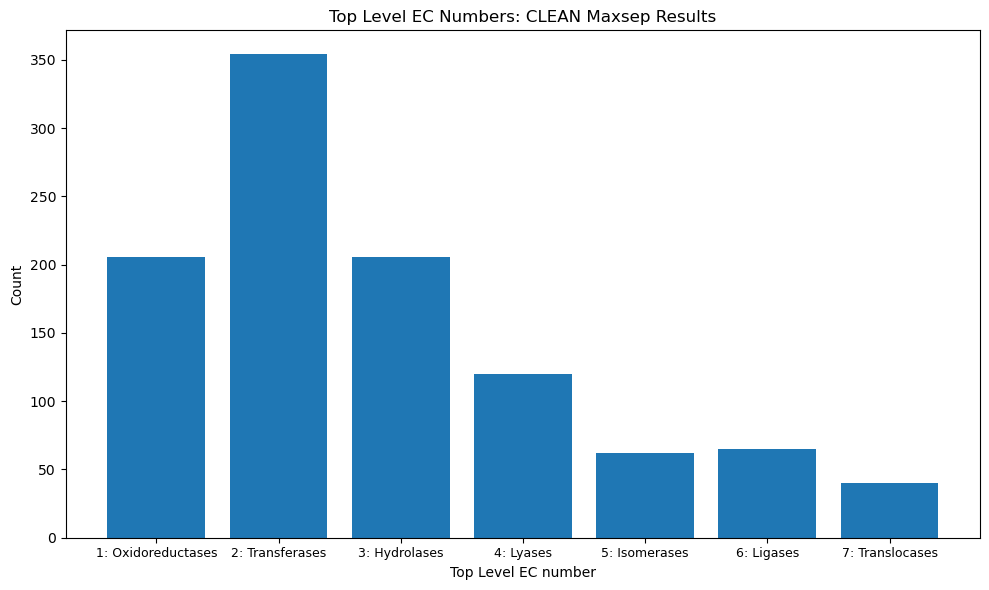

In [8]:
visualize_first_digits_distribution(set(clean_maxsep_ec_list), 'Top Level EC Numbers: CLEAN Maxsep Results')

In [9]:
# BioCyc dataset
biocyc = pd.read_csv('biocyc_updated.csv')
print("row and col numbers for biocyc dataframe:", biocyc.shape)
print("Number of non-NaN values in the 'BioCyc EC' column:", biocyc['BioCyc EC'].count())
print("Number of non-NaN values in the 'UniProt' column:", biocyc['UniProt'].count())

# these are all the unique EC numbers from the BioCyc data 
# some of these EC numbers do not have a UniProt id entry for that row
biocyc_ec_list = list_of_unique_ecs(biocyc, 'BioCyc EC')
print("unique number of ec numbers in BioCyc dataset:", len(biocyc_ec_list))

row and col numbers for biocyc dataframe: (728, 7)
Number of non-NaN values in the 'BioCyc EC' column: 691
Number of non-NaN values in the 'UniProt' column: 721
unique number of ec numbers in BioCyc dataset: 605


In [10]:
biocyc

,UniProt,Genes of a reaction from All instances of Reactions in Prochlorococcus marinus pastoris CCMP1986,Matches,Accession-1,Accession-2,Gene products (polypeptides and RNAs only),BioCyc EC
0,Q7V2E7,aarA,octadecanal + acyl-carrier protein + NAD(P)+ ...,PMM0533,TX50_RS02855,long-chain acyl-[acyl-carrier-protein] reductase,EC:1.2.1.80
1,Q7V2E6,accA,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0534,TX50_RS02860,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
2,Q7TUH9,accB,ATP + acetyl-CoA + hydrogencarbonate -> ADP ...,PMM0027,TX50_RS00150,acetyl-CoA carboxylase biotin carboxyl carrier...,EC:6.4.1.2
3,Q7V3L5,accC,a [biotin carboxyl-carrier-protein dimer]-N6-b...,PMM0060,TX50_RS00320,acetyl-CoA carboxylase biotin carboxylase subunit,EC:6.3.4.14
4,Q7V1S1,accD,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0784,TX50_RS04185,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
...,...,...,...,...,...,...,...
723,NaN,ycf12,RXN-15490 // oxygen[in] + 4 H+[in] + 4 e-[memb...,NaN,NaN,photosystem II reaction center protein Ycf12,"EC:1.1.3, EC:1.10.3.9"
724,Q7V0W4,ychF,ATP + H2O -> ADP + phosphate + H+,PMM1138,TX50_RS06135,redox-regulated ATPase YchF,EC:3.6.1.15
725,Q7V3G0,zds,beta-zeacarotene + an electron-transfer quinon...,PMM0115,TX50_RS00605,"9,9'-di-cis-zeta-carotene desaturase",EC:1.3.5.6
726,Q7V3E5,zntA,a metal cation[out] + ATP + H2O -> a metal c...,PMM0131,TX50_RS00690,P-type cation transporter,NaN


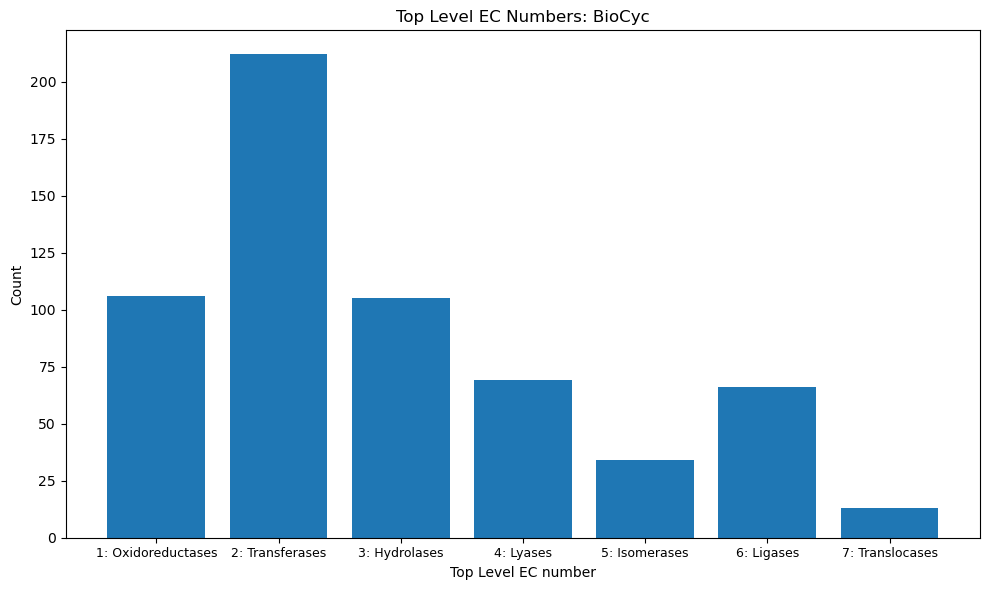

In [11]:
visualize_first_digits_distribution(set(biocyc_ec_list), 'Top Level EC Numbers: BioCyc')

### Combine separate dataset visuals into one to look at all unique EC numbers, by top level EC number

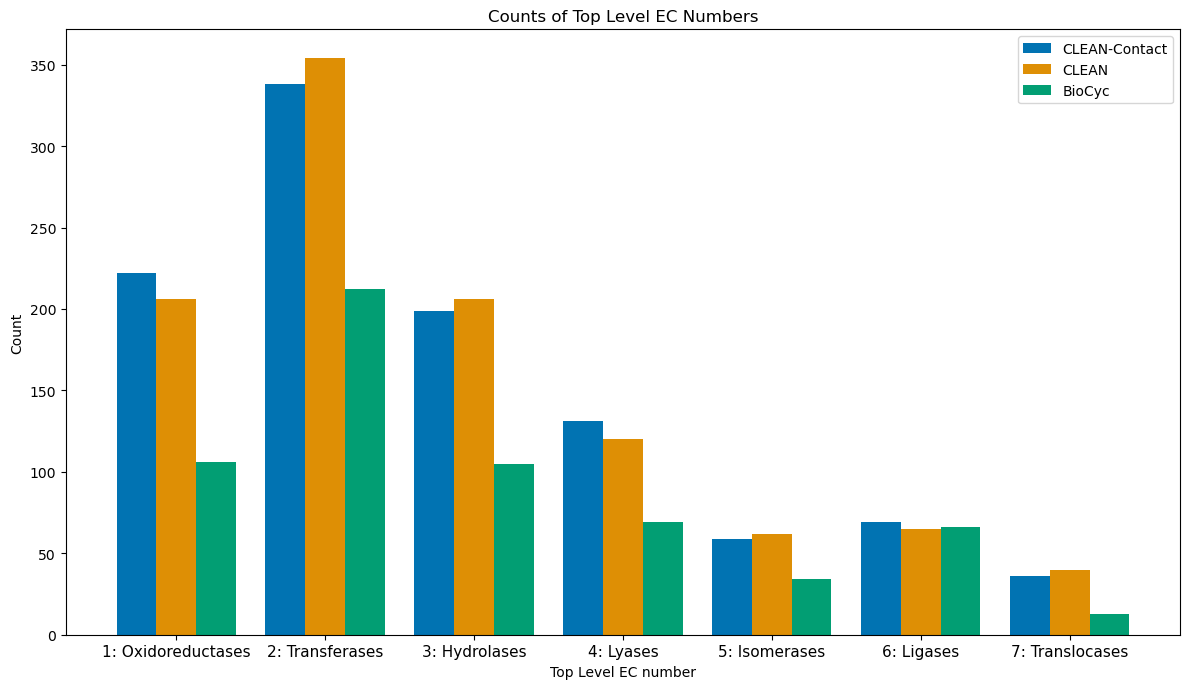

In [12]:
# these are the unique ec numbers found in each of the 3 datasets, representing the metabolic capabilities of the 
# organism according to each dataset
# this visual is the actual counts of ec numbers with the corresponding top level ec number per dataset 
# recall that these datasets started with different row numbers from each other, so the next visual 
# with the percentages is also provided for clearer comparisons
all_sets = [set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers", custom_labels)

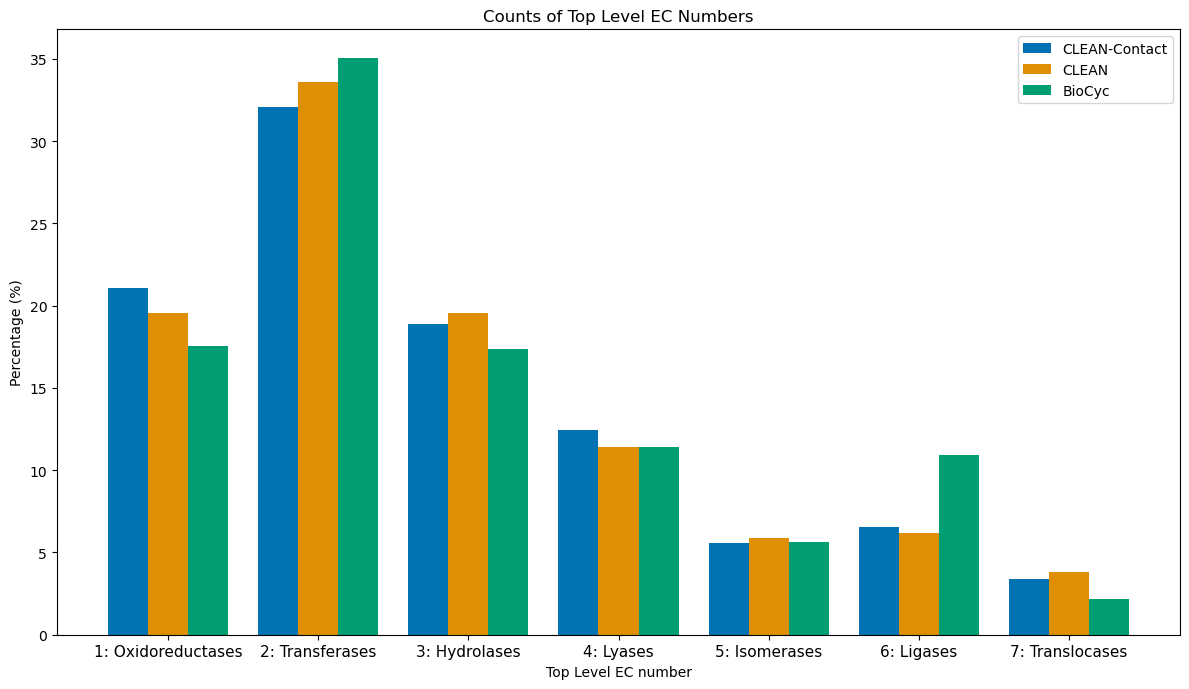

In [13]:
# each input set was the unique list of ec numbers in that dataset, and percent is calculated per set 
# example: the left-most blue bar for top level 1 means from the unique ec 
# numbers predicted by CLEAN-Contact, around 20% of all those unique ec numbers started with 1
all_sets = [set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers", custom_labels, use_percent=True)
# without using a confidence score threshold, this looks like CLEAN-Contact provided proportionately more 
# oxidoreductases, lysases, and ligases than CLEAN

### Analyze unions and intersections of the 3 datasets

In [14]:
# calculate the subsets
only_cc_maxsep, only_clean_maxsep, only_biocyc, cc_maxsep_and_clean_maxsep, cc_maxsep_and_biocyc, clean_maxsep_and_biocyc, all_three = calculate_subsets(cc_maxsep_ec_list, clean_maxsep_ec_list, biocyc_ec_list)
print("only in cc:", len(only_cc_maxsep)) 
print("only in clean:", len(only_clean_maxsep)) 
print("only in biocyc:", len(only_biocyc)) 
print("in cc and clean:", len(cc_maxsep_and_clean_maxsep)) 
print("in cc and biocyc:", len(cc_maxsep_and_biocyc)) 
print("in clean and biocyc:", len(clean_maxsep_and_biocyc)) 
print("in all three:", len(all_three))

only in cc: 350
only in clean: 352
only in biocyc: 119
in cc and clean: 244
in cc and biocyc: 29
in clean and biocyc: 26
in all three: 431


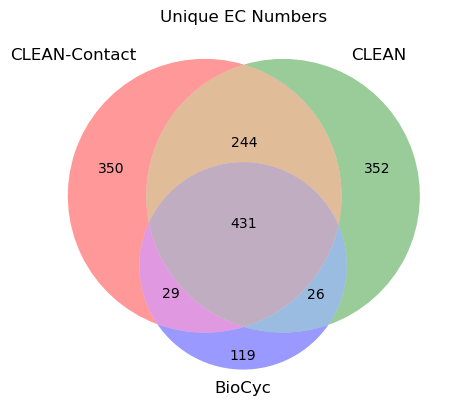

In [15]:
# venn diagram for all unique ec numbers in the three datasets
# note: at this point the datasets still have different UniProt ids and there hasn't been any filter for confidence scores
venn3([set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title('Unique EC Numbers')
plt.show()

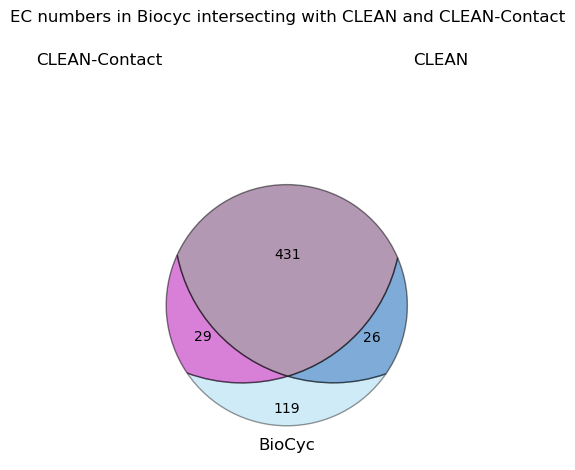

In [16]:
# look at just the purple BioCyc section of the above venn diagram
venn = venn3([set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))

# make the patches for Set 2 and Set 3 clear
# comment this part out to keep the other circles in the visual
for id_ in ['100', '110', '111', '101', '010']:
    if venn.get_patch_by_id(id_):
        venn.get_patch_by_id(id_).set_alpha(0)

if venn.get_patch_by_id('001'):
    venn.get_patch_by_id('001').set_color('skyblue')
    venn.get_patch_by_id('001').set_edgecolor('black')

if venn.get_patch_by_id('011'):
    venn.get_patch_by_id('011').set_edgecolor('black')
    venn.get_patch_by_id('011').set_alpha(0.5)

if venn.get_patch_by_id('101'):
    venn.get_patch_by_id('101').set_edgecolor('black')
    venn.get_patch_by_id('101').set_alpha(0.5)
    
if venn.get_patch_by_id('111'):
    venn.get_patch_by_id('111').set_edgecolor('black')
    venn.get_patch_by_id('111').set_alpha(0.5)

for id_ in ['010', '110', '100']:
    if venn.get_label_by_id(id_):
        venn.get_label_by_id(id_).set_text('')
        
# remove the labels 
#venn.get_label_by_id('A').set_text('')
#venn.get_label_by_id('B').set_text('')

plt.title("EC numbers in Biocyc intersecting with CLEAN and CLEAN-Contact")
plt.tight_layout()
plt.show()


### Previously visualized the distributions of top level EC numbers in each of the 3 datasets, now visualize those distributions in each of the subsets from the venn diagram

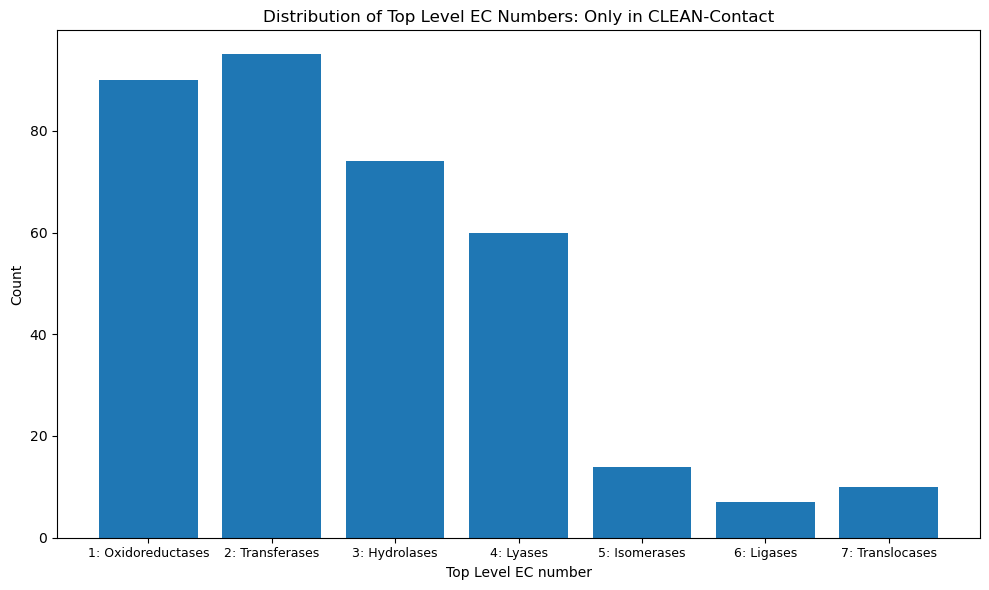

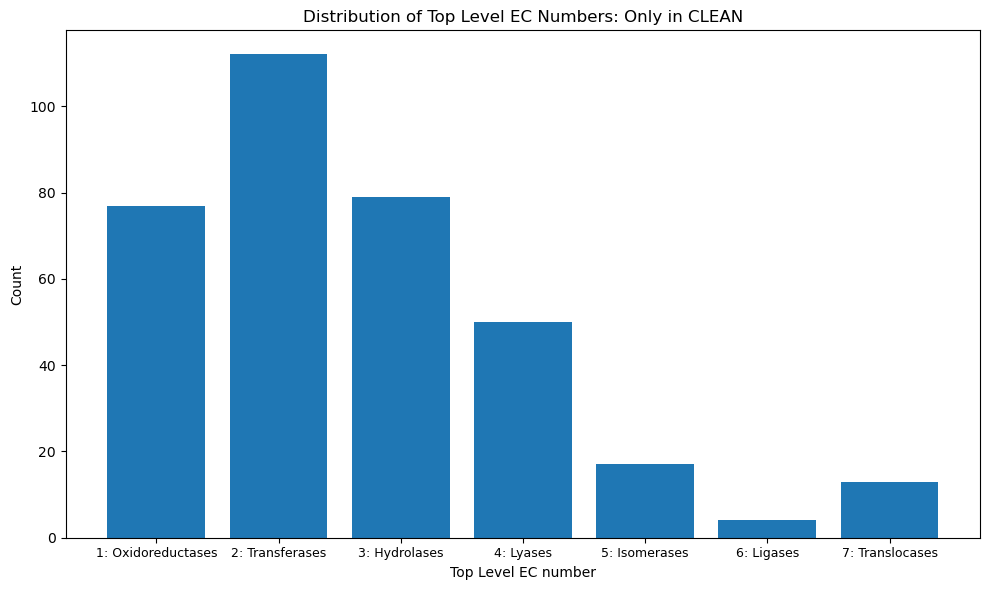

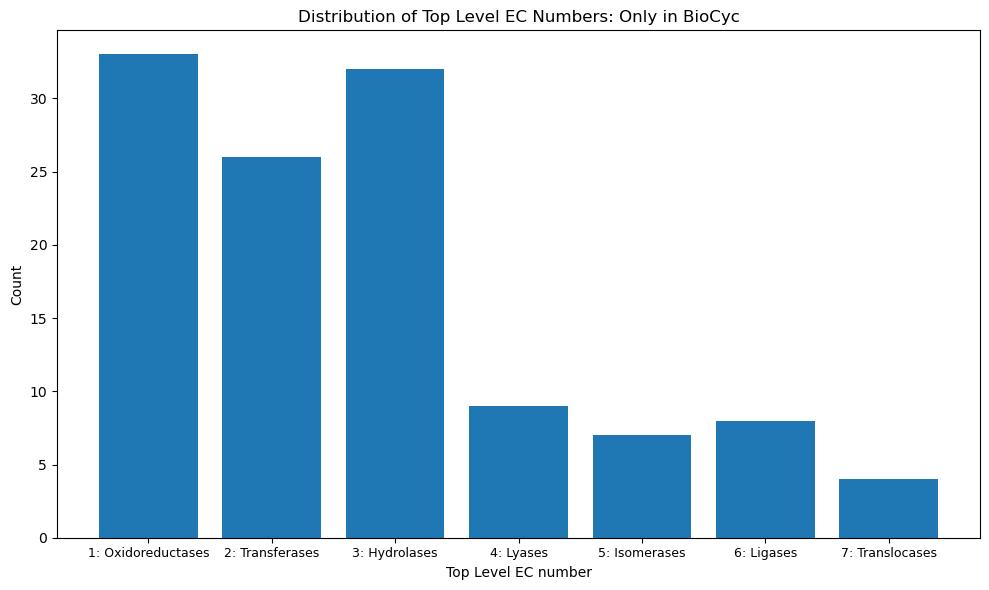

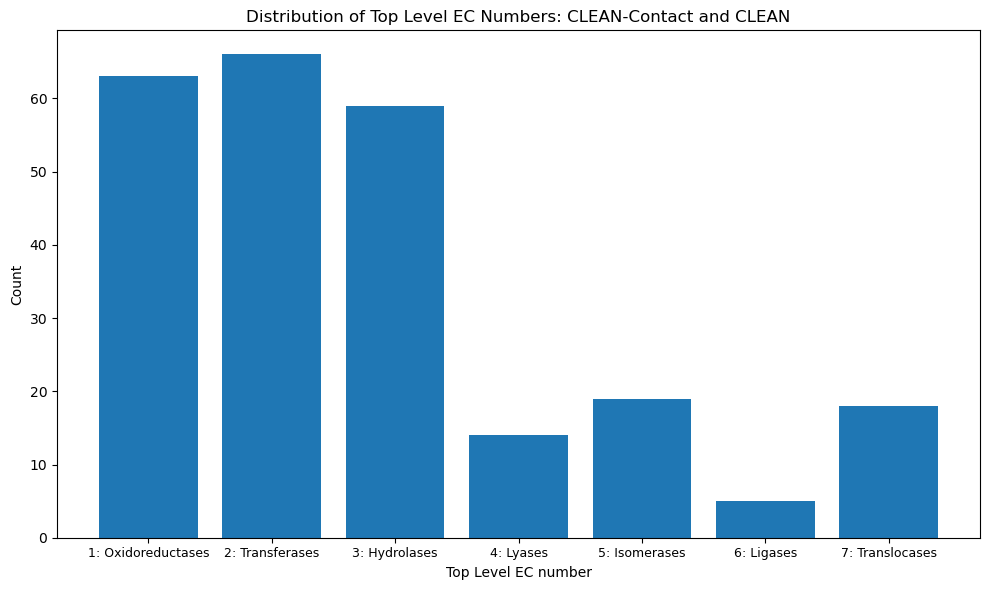

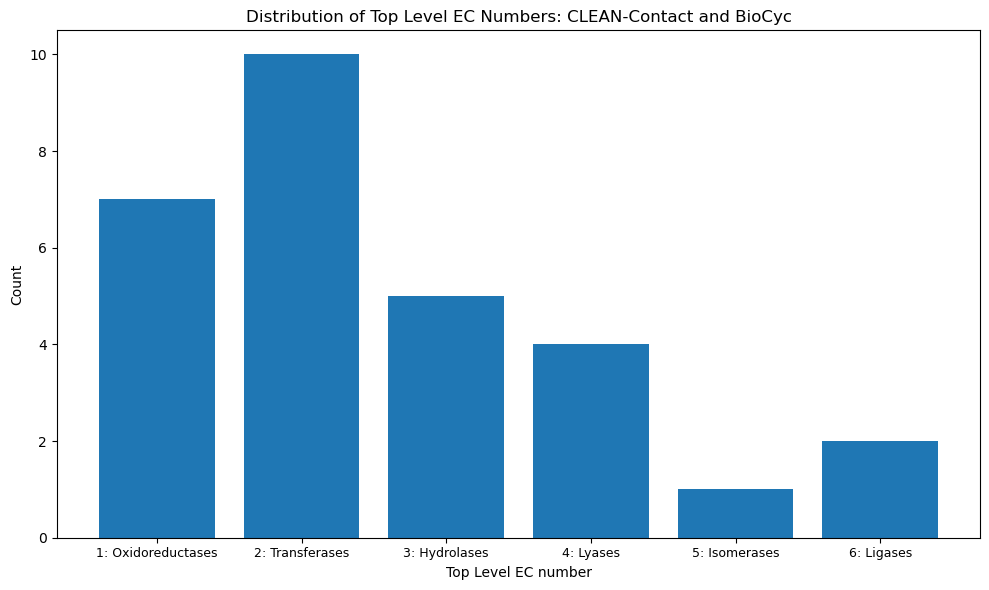

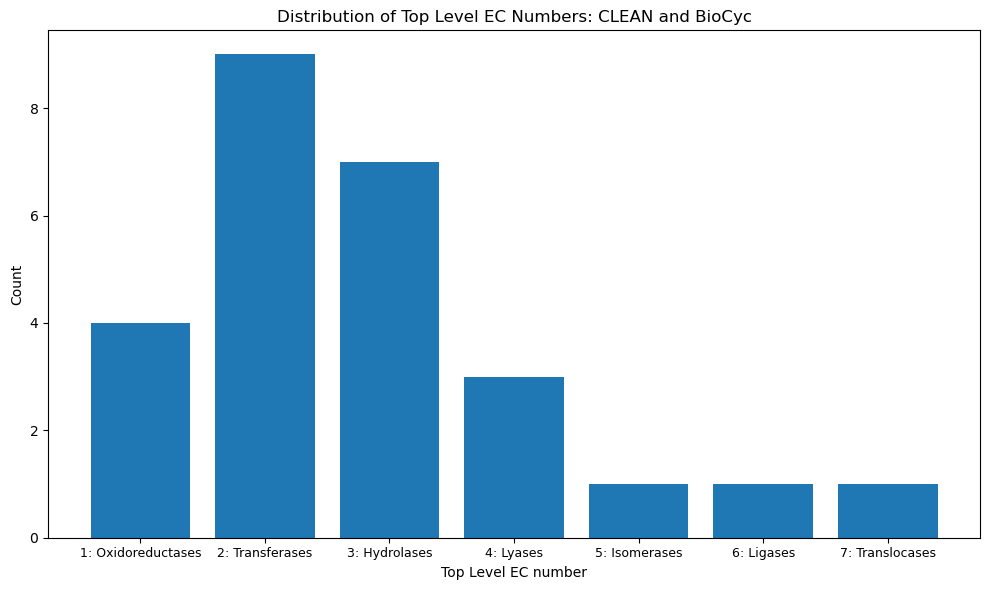

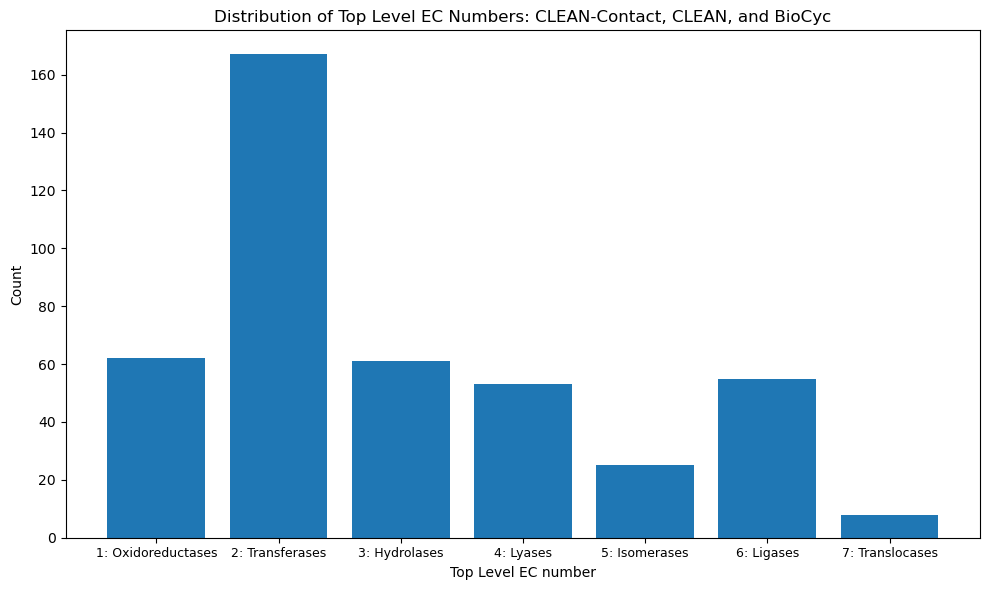

In [17]:
visualize_first_digits_distribution(only_cc_maxsep, 'Distribution of Top Level EC Numbers: Only in CLEAN-Contact')
# include True param for percentage not counts
#visualize_first_digits_distribution(only_cc_maxsep, 'Distribution of Top Level EC Numbers: Only in CLEAN-Contact', True)

visualize_first_digits_distribution(only_clean_maxsep, 'Distribution of Top Level EC Numbers: Only in CLEAN')
visualize_first_digits_distribution(only_biocyc, 'Distribution of Top Level EC Numbers: Only in BioCyc')
visualize_first_digits_distribution(cc_maxsep_and_clean_maxsep, 'Distribution of Top Level EC Numbers: CLEAN-Contact and CLEAN')
visualize_first_digits_distribution(cc_maxsep_and_biocyc, 'Distribution of Top Level EC Numbers: CLEAN-Contact and BioCyc')
visualize_first_digits_distribution(clean_maxsep_and_biocyc, 'Distribution of Top Level EC Numbers: CLEAN and BioCyc')
visualize_first_digits_distribution(all_three, 'Distribution of Top Level EC Numbers: CLEAN-Contact, CLEAN, and BioCyc')

### Analyze the confidence scores for CLEAN and CLEAN-Contact datasets

In [18]:
def separate_results(input_df, columns_to_split):
    # separate the rows with multiple results into multiple rows with one result per row
    df = input_df.copy()
    
    # split the results in each entry
    for column in columns_to_split:
        df[column] = df[column].str.split(',')
    
    # expand the DataFrame so that each list entry creates a new row
    df = df.explode(columns_to_split).reset_index(drop=True)
    
    # remove the whitespaces
    for column in columns_to_split:
        df[column] = df[column].str.strip()

    return df

In [19]:
# prep clean-contact results to analyze confidence scores
columns_to_split = ['CC maxsep EC', 'CC maxsep conf', 'CC maxsep conf SD', 'CC maxsep cluster dist']
cc_maxsep_expanded = separate_results(cc_maxsep, columns_to_split)
cc_maxsep_expanded['CC maxsep conf'] = pd.to_numeric(cc_maxsep_expanded['CC maxsep conf'])

In [20]:
# prep clean results to analyze confidence scores
clean_maxsep_cols = ['Clean maxsep EC', 'Clean maxsep conf']
clean_expanded = separate_results(clean_results, clean_maxsep_cols)
# pvalue cols not necessary to separate out here since they don't contain confidence scores
#clean_pvalue_cols = ['Clean pvalue EC', 'Clean pvalue cluster dist']
#clean_expanded = separate_results(clean_expanded, clean_pvalue_cols )
clean_expanded['Clean maxsep conf']= pd.to_numeric(clean_expanded['Clean maxsep conf'])

#### Combined probabilities section

$ P_{\text{combined}} = 1 - \prod_{i=1}^{n} (1 - P_i) $

example:
1-((1-0.9954)*(1-0.0063)*(1-0.0045)) = 0.99544954959

In [21]:
def get_conf_for_unique_ec(unique_ec_list, df, ec_col, conf_col):
    # get all confidence scores per unique ec number and store in a dict
    ec_conf_dict = {}
    
    # iterate through list of unique EC numbers
    for ec in unique_ec_list:
        # filter the DataFrame for rows where the ec_col contains each unique ec number
        matched_rows = df[df[ec_col] == ec]

        # using the filtered dataframe, retrieve the confidence column's values 
        conf_values = matched_rows[conf_col].tolist()

        # values will be list of floats
        # keys are the ec numbers in string format of: 'EC:1.1.1.1'
        ec_conf_dict[ec] = conf_values
        
    return ec_conf_dict

def combined_probability(conf_values):
    # Convert all entries to float
    conf_values = [float(conf) for conf in conf_values]
    return 1 - np.prod([1 - conf for conf in conf_values])

def calculate_combined_prob(ec_conf_dict):
    # New dictionary to store combined probabilities
    ec_combined_prob_dict = {}

    # Calculate the combined probability for each EC number
    for ec, conf_values in ec_conf_dict.items():
        combined_prob = combined_probability(conf_values)
        ec_combined_prob_dict[ec] = combined_prob

    return ec_combined_prob_dict

def create_bar_chart(ec_dict, top_level):
    # create a bar chart for a given group
    ec_numbers = list(ec_dict.keys())
    probabilities = list(ec_dict.values())

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the bar chart
    bars = ax.bar(ec_numbers, probabilities, color='skyblue')

    # Add labels and title
    ax.set_xlabel('EC Number')
    ax.set_ylabel('Combined Probability')
    ax.set_title(f'Combined Probabilities for EC Numbers with Top-Level Class {top_level}')

    # Add probability labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

def group_combined_proba_keep_ec(comb_prob_dict):
    # create dict that groups the combined probability dicts into dict keys that have the top level ec number
    grouped_data = {}
    for ec, prob in comb_prob_dict.items():
        top_level = ec.split(':')[1].split('.')[0]  # Extract the top-level number
        if top_level not in grouped_data:
            grouped_data[top_level] = {}
        grouped_data[top_level][ec] = prob
    
    return grouped_data

def group_combined_proba(comb_prob_dict):
    grouped_data = {}
    # group without tracking ec number to probability relationship, just view probabilities by group
    for ec, prob in comb_prob_dict.items():
        top_level = ec.split(':')[1].split('.')[0]  # Extract the top-level number
        if top_level not in grouped_data:
            grouped_data[top_level] = []
        grouped_data[top_level].append(prob)
    
    return grouped_data

def boxplots_both_combined_proba(d1, d2):
    # converting data to long-format for seaborn compatibility
    d1_long = d1.melt(var_name='Top-Level EC Number', value_name='Combined Probability')
    d1_long['Dataset'] = 'CLEAN-Contact'
    d2_long = d2.melt(var_name='Top-Level EC Number', value_name='Combined Probability')
    d2_long['Dataset'] = 'CLEAN'

    # combine the two DataFrames
    combined_df = pd.concat([d1_long, d2_long], ignore_index=True)
    return combined_df
    # create the plot
    fig, ax = plt.subplots(figsize=(14, 10))
    fig.suptitle("Combined Probabilities by Top-Level EC Number")

    sns.boxplot(data=combined_df, x='Top-Level EC Number', y='Combined Probability', hue='Dataset', ax=ax, width=.5, palette="Set3")
    sns.stripplot(data=combined_df, x='Top-Level EC Number', y='Combined Probability', hue='Dataset', dodge=True, marker='o', ax=ax, palette='dark')

    # Customize legend to avoid duplicate entries
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc='upper left')

    # Setting axis labels
    ax.set_xlabel('Top-Level EC Number')
    ax.set_ylabel('Combined Probability')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [22]:
# clean-contact combined probabilities
# create dict with 1054 unique ec numbers as keys, keep list of associated confidence scores as values
# example key value pair: 'EC:1.1.1.100': [0.9954, 0.0063, 0.0045]
cc_ec_conf_dict = get_conf_for_unique_ec(cc_maxsep_ec_list, cc_maxsep_expanded, 'CC maxsep EC', 'CC maxsep conf')

# using all confidences for each unique ec number, calculate combined probability per ec number
# keys still ec numbers, value now just the one probability per ec number
cc_combined_prob = calculate_combined_prob(cc_ec_conf_dict)

# group the ec numbers into same top level ec number as keys, values are list of all associated probabilities
cc_combined_prob_grouped = group_combined_proba(cc_combined_prob)

# create a dataframe for plotting, cols are top level ec numbers, rows are their probabilities
cc_combined_prob_grouped_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cc_combined_prob_grouped.items()]))

In [23]:
# clean combined probabilities
# create dict with 1053 unique ec numbers as keys, keep list of associated confidence scores as values
clean_ec_conf_dict = get_conf_for_unique_ec(clean_maxsep_ec_list, clean_expanded, 'Clean maxsep EC', 'Clean maxsep conf')

# using all confidences for each unique ec number, calculate combined probability per ec number
# keys still ec numbers, value now just the one probability per ec number
clean_combined_prob = calculate_combined_prob(clean_ec_conf_dict)

# group the ec numbers into same top level ec number as keys, values are list of all associated probabilities
clean_combined_prob_grouped = group_combined_proba(clean_combined_prob)

# create a dataframe for plotting, cols are top level ec numbers, rows are their probabilities
clean_combined_prob_grouped_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in clean_combined_prob_grouped.items()]))

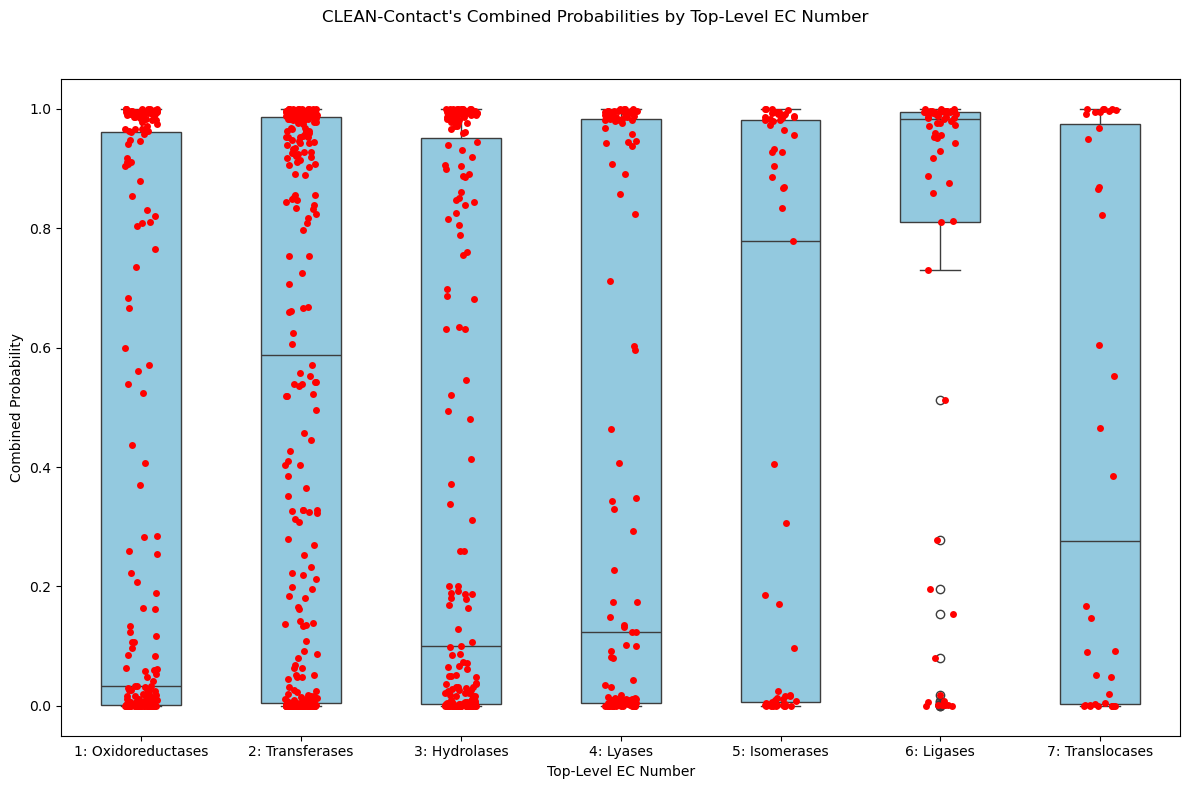

In [24]:
# individual plot for clean-contact
class_names = {
    '1': 'Oxidoreductases',
    '2': 'Transferases',
    '3': 'Hydrolases',
    '4': 'Lyases',
    '5': 'Isomerases',
    '6': 'Ligases',
    '7': 'Translocases'
}
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("CLEAN-Contact's Combined Probabilities by Top-Level EC Number")

sns.boxplot(data=cc_combined_prob_grouped_df, ax=ax, color='skyblue', width=.5)
sns.stripplot(data=cc_combined_prob_grouped_df, ax=ax, color='red', jitter=True)

plt.xlabel('Top-Level EC Number')
plt.ylabel('Combined Probability')

labels = [f'{i}: {class_names.get(i, "Unknown Class")}' for i in cc_combined_prob_grouped_df.columns]
ax.set_xticks(range(cc_combined_prob_grouped_df.shape[1]))
ax.set_xticklabels(labels)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

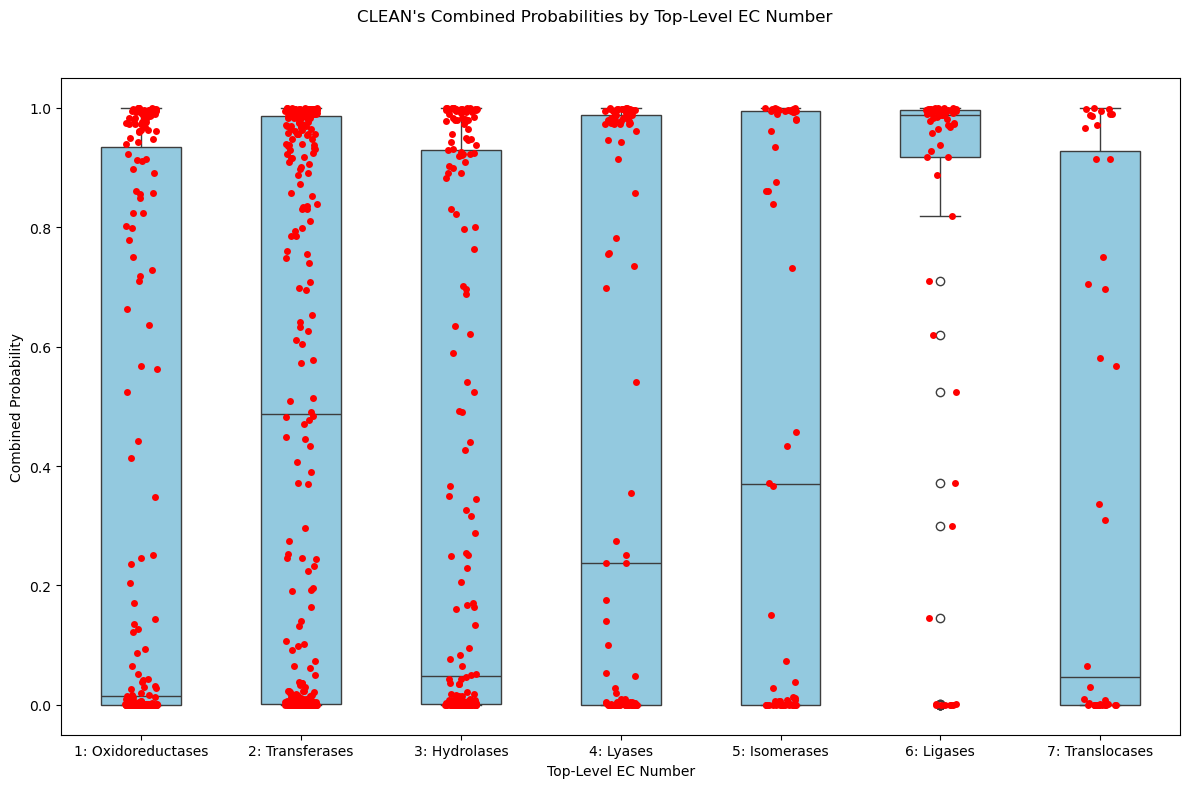

In [25]:
# individual plot for clean
class_names = {
    '1': 'Oxidoreductases',
    '2': 'Transferases',
    '3': 'Hydrolases',
    '4': 'Lyases',
    '5': 'Isomerases',
    '6': 'Ligases',
    '7': 'Translocases'
}

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("CLEAN's Combined Probabilities by Top-Level EC Number")

sns.boxplot(data=clean_combined_prob_grouped_df, ax=ax, color='skyblue', width=.5)
sns.stripplot(data=clean_combined_prob_grouped_df, ax=ax, color='red', jitter=True)

plt.xlabel('Top-Level EC Number')
plt.ylabel('Combined Probability')

labels = [f'{i}: {class_names.get(i, "Unknown Class")}' for i in clean_combined_prob_grouped_df.columns]
ax.set_xticks(range(clean_combined_prob_grouped_df.shape[1]))
ax.set_xticklabels(labels)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [26]:
# plot both datasets together
boxplots_both_combined_proba(cc_combined_prob_grouped_df, clean_combined_prob_grouped_df)

,Top-Level EC Number,Combined Probability,Dataset
0,1,0.811100,CLEAN-Contact
1,1,0.995450,CLEAN-Contact
2,1,0.063042,CLEAN-Contact
3,1,0.027600,CLEAN-Contact
4,1,0.011800,CLEAN-Contact
...,...,...,...
4839,7,NaN,CLEAN
4840,7,NaN,CLEAN
4841,7,NaN,CLEAN
4842,7,NaN,CLEAN


# confidence score threshold section

Recall that 1 UniProt id can have multiple EC number predictions and thus confidence scores. At this point, we already have dataframes of these expanded results, so each row only has 1 EC number and its 1 confidence score for the 1 UniProt id in that row. The below visuals include:

* all confidence scores for the 1939 UniProt ids in CLEAN-Contact results 
     * there are 977 unique values for the confidence scores
     * total 2327 rows of results when the data is separated so each UniProt id has one ec prediction/confidence score
        
* all confidence scores for the 1942 UniProt ids in CLEAN results
     * there are 837 unique values for the confidence scores
     * total 2341 rows of results when the data is separated so each UniProt id has one ec prediction/confidence score


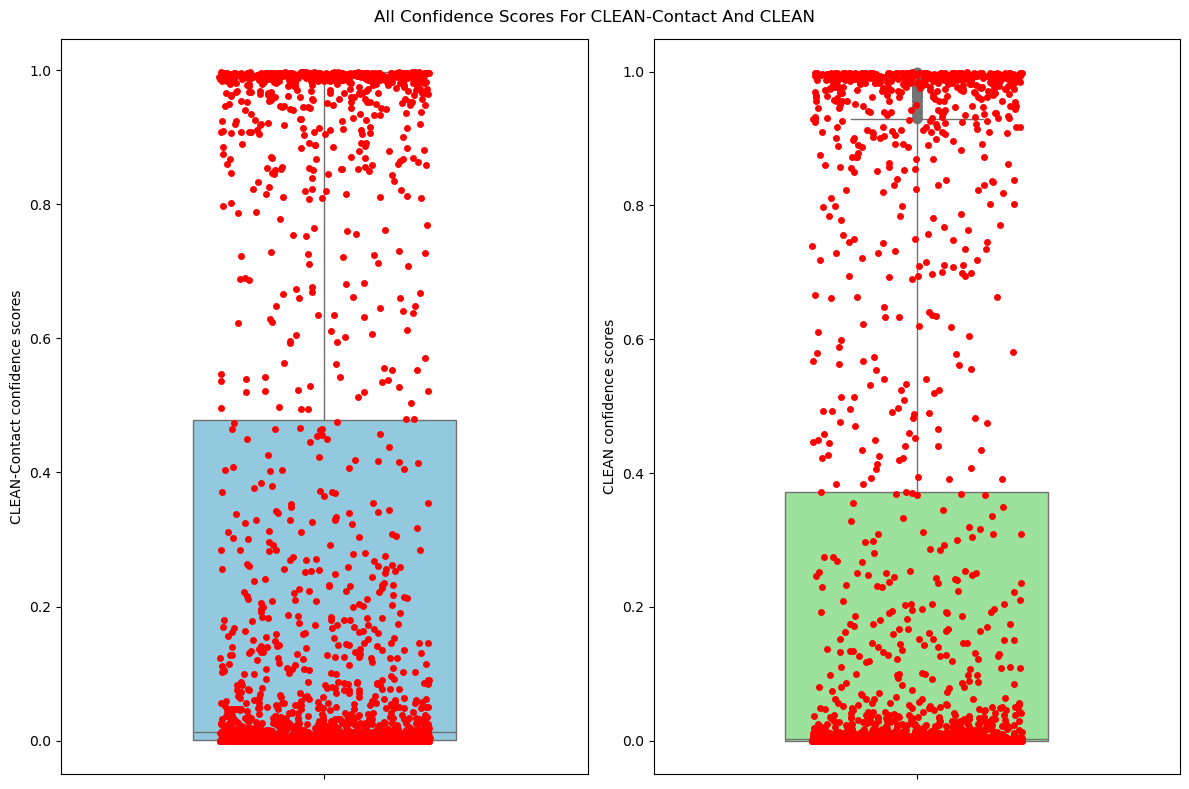

In [27]:
# comment out the 2 sns.stripplot() lines to view the boxplots without the red dots
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

sns.boxplot(data=cc_maxsep_expanded, y='CC maxsep conf', ax=axs[0], color='skyblue', width=.5)
sns.stripplot(data=cc_maxsep_expanded, y='CC maxsep conf', ax=axs[0], color='red', jitter=0.2)
axs[0].set_ylabel('CLEAN-Contact confidence scores')

sns.boxplot(data=clean_expanded, y='Clean maxsep conf', ax=axs[1], color='lightgreen', width=.5)
sns.stripplot(data=clean_expanded, y='Clean maxsep conf', ax=axs[1], color='red', jitter=0.2)
axs[1].set_ylabel('CLEAN confidence scores')

fig.suptitle('All Confidence Scores For CLEAN-Contact And CLEAN')

plt.tight_layout()
plt.show()

In [28]:
# look at the summary stats for the all confidence scores
print("CLEAN-Contact confidence scores summary")
print(cc_maxsep_expanded['CC maxsep conf'].describe(), "\n")

print("CLEAN confidence scores summary")
print(clean_expanded['Clean maxsep conf'].describe())

CLEAN-Contact confidence scores summary
count    2327.000000
mean        0.258521
std         0.392118
min         0.000000
25%         0.001000
50%         0.012500
75%         0.477800
max         0.996400
Name: CC maxsep conf, dtype: float64 

CLEAN confidence scores summary
count    2341.000000
mean        0.238374
std         0.389193
min         0.000000
25%         0.000200
50%         0.003300
75%         0.372000
max         0.998900
Name: Clean maxsep conf, dtype: float64


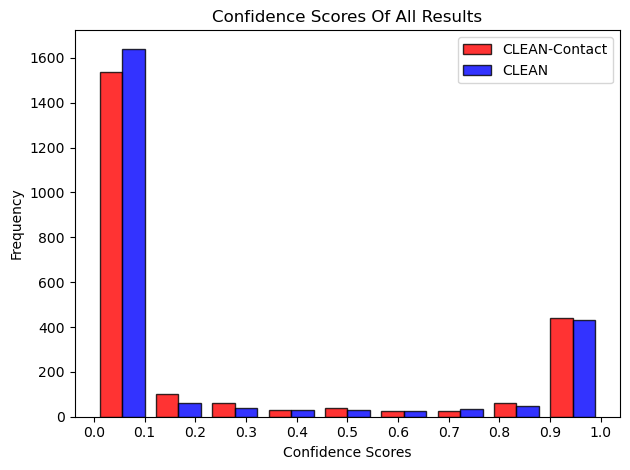

Chi-Square Statistic: 21.41985265723892
P-Value: 0.006111918217556259
The datasets have a statistically significant difference for the bins (p <= 0.05).


In [29]:
bins = np.linspace(0, 1, 10) 
plt.hist([cc_maxsep_expanded['CC maxsep conf'], clean_expanded['Clean maxsep conf']],
          bins=bins, color=['r', 'b'], alpha=0.8, label=['CLEAN-Contact', 'CLEAN'], edgecolor='black')

plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title("Confidence Scores Of All Results")

plt.legend(loc='upper right')
x_ticks = np.arange(0, 1.01, 0.1)
plt.xticks(x_ticks)
plt.tight_layout()

# uncomment savefig command to download plot as a .png
#plt.savefig('histogram_confidences_all.png', format='png', dpi=300, bbox_inches='tight')

# plt.show() has to be run after plt.savefig
plt.show()

# perform Chi-Square test even though I'm not 100% sure its helpful here? remove everything in this cell below if this
# test is not worth reporting
# calculate histogram counts 
cc_counts, _ = np.histogram(cc_maxsep_expanded['CC maxsep conf'], bins=bins)
clean_counts, _ = np.histogram(clean_expanded['Clean maxsep conf'], bins=bins)

# apply continuity correction by adding a small value to all counts if one bin has 0 counts in it
#cc_counts += .1
#clean_counts += .1

# use chi2_contingency not chisquare since there's not an expected distribution and observed; we're 
# comparing two different datasets to test if their distribution is the same
chi2_stat, p_val, dof, ex = chi2_contingency([cc_counts, clean_counts])

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# determine statistical significance
alpha = 0.05  
if p_val <= alpha:
    print("The datasets have a statistically significant difference for the bins (p <= 0.05).")
else:
    print("The datasets do not have a statistically significant difference for the bins (p > 0.05).")

### Find a confidence score cutoff and recreate some of the previous visuals

In [30]:
cutoff = 0.1

cc_filtered_conf = cc_maxsep_expanded[cc_maxsep_expanded['CC maxsep conf'] > cutoff]
print("CLEAN-Contact filtered dataframe shape:", cc_filtered_conf.shape)
clean_filtered_conf = clean_expanded[clean_expanded['Clean maxsep conf'] > cutoff]
print("CLEAN filtered dataframe shape:", clean_filtered_conf.shape)

CLEAN-Contact filtered dataframe shape: (805, 7)
CLEAN filtered dataframe shape: (707, 7)


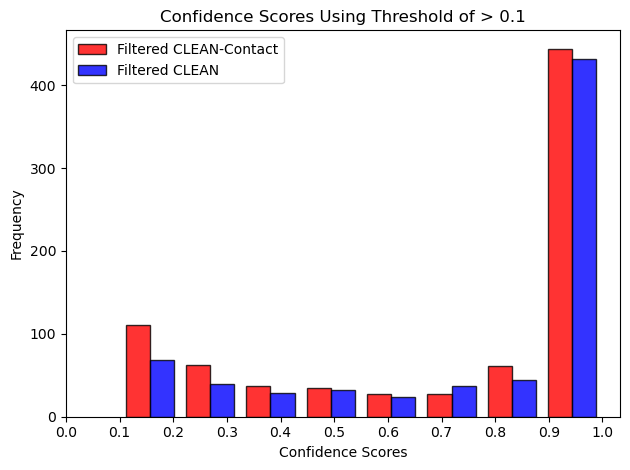

Chi-Square Statistic: 14.143645227947893
P-Value: 0.04868467553101896
The datasets have a statistically significant difference for the bins (p <= 0.05).


In [31]:
bins = np.linspace(0.1, 1, 9) # keep this as bins for cutoff of 0.1
plt.hist([cc_filtered_conf['CC maxsep conf'], clean_filtered_conf['Clean maxsep conf']],
          bins=bins, color=['r', 'b'], alpha=0.8, label=['Filtered CLEAN-Contact', 'Filtered CLEAN'], edgecolor='black')

plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title(f'Confidence Scores Using Threshold of > {cutoff}')

plt.legend(loc='upper left')
x_ticks = np.arange(0, 1.01, 0.1)
plt.xticks(x_ticks)
plt.tight_layout()
plt.show()

# calculate histogram counts 
cc_counts, _ = np.histogram(cc_filtered_conf['CC maxsep conf'], bins=bins)
clean_counts, _ = np.histogram(clean_filtered_conf['Clean maxsep conf'], bins=bins)

# apply continuity correction by adding a small value to all counts if one bin has 0 counts in it
#cc_counts += .1
#clean_counts += .1

# perform Chi-Square test even though I'm not 100% sure its helpful here?
# use chi2_contingency not chisquare since there's not an expected distribution and observed; we're 
# comparing two different datasets to test if their distribution is the same
chi2_stat, p_val, dof, ex = chi2_contingency([cc_counts, clean_counts])

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# determine statistical significance
alpha = 0.05  
if p_val <= alpha:
    print("The datasets have a statistically significant difference for the bins (p <= 0.05).")
else:
    print("The datasets do not have a statistically significant difference for the bins (p > 0.05).")

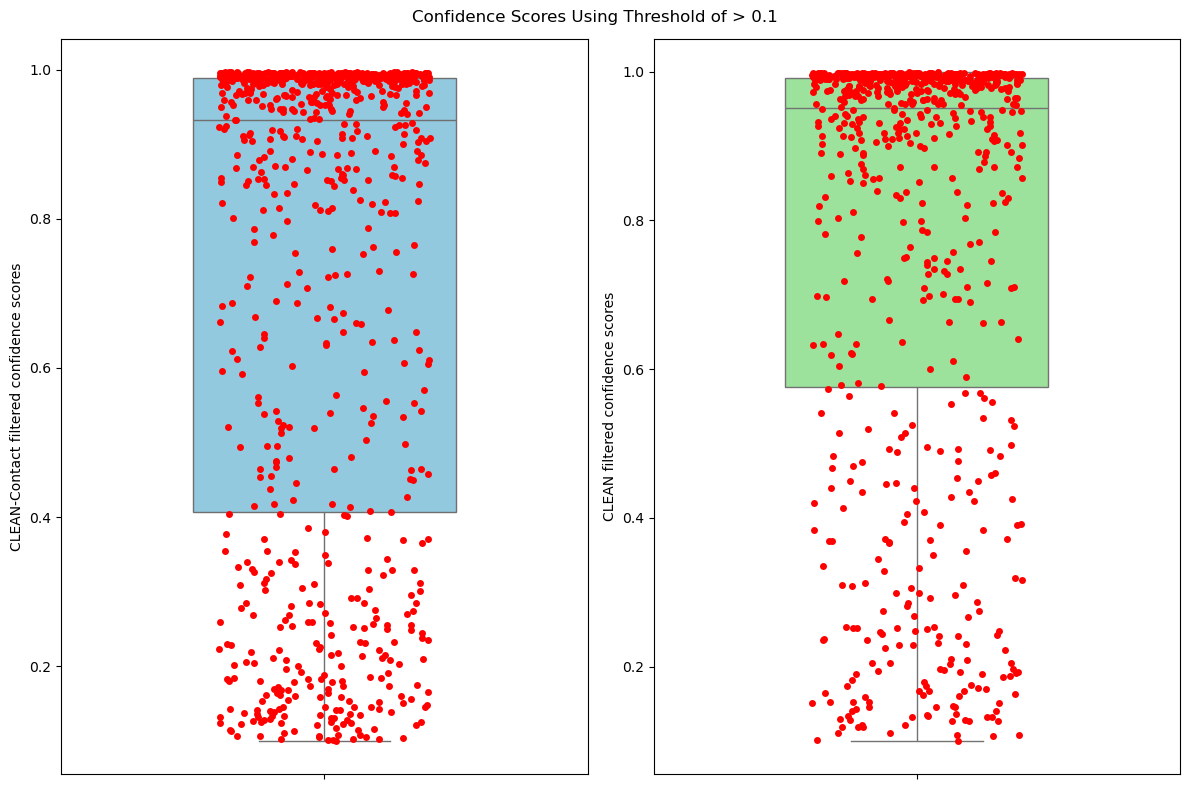

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

sns.boxplot(data=cc_filtered_conf, y='CC maxsep conf', ax=axs[0], color='skyblue', width=.5)
sns.stripplot(data=cc_filtered_conf, y='CC maxsep conf', ax=axs[0], color='red', jitter=0.2)
axs[0].set_ylabel('CLEAN-Contact filtered confidence scores')

sns.boxplot(data=clean_filtered_conf, y='Clean maxsep conf', ax=axs[1], color='lightgreen', width=.5)
sns.stripplot(data=clean_filtered_conf, y='Clean maxsep conf', ax=axs[1], color='red', jitter=0.2)
axs[1].set_ylabel('CLEAN filtered confidence scores')

fig.suptitle(f'Confidence Scores Using Threshold of > {cutoff}')

plt.tight_layout()
plt.show()

In [33]:
print("Filtered CLEAN-Contact confidence scores summary")
print(cc_filtered_conf['CC maxsep conf'].describe(), "\n")

print("Filtered CLEAN confidence scores summary")
print(clean_filtered_conf['Clean maxsep conf'].describe())

Filtered CLEAN-Contact confidence scores summary
count    805.000000
mean       0.727505
std        0.327870
min        0.100100
25%        0.407100
50%        0.932900
75%        0.989200
max        0.996400
Name: CC maxsep conf, dtype: float64 

Filtered CLEAN confidence scores summary
count    707.000000
mean       0.774476
std        0.298685
min        0.100300
25%        0.575400
50%        0.950600
75%        0.991500
max        0.998900
Name: Clean maxsep conf, dtype: float64


In [34]:
cc_ec_list = list_of_unique_ecs(cc_filtered_conf, 'CC maxsep EC')
print("unique number of ec numbers in the filtered CLEAN-Contact dataset:", len(cc_ec_list)) 
clean_ec_list = list_of_unique_ecs(clean_filtered_conf, 'Clean maxsep EC')
print("unique number of ec numbers in the filtered CLEAN dataset:", len(clean_ec_list)) 

unique number of ec numbers in the filtered CLEAN-Contact dataset: 589
unique number of ec numbers in the filtered CLEAN dataset: 559


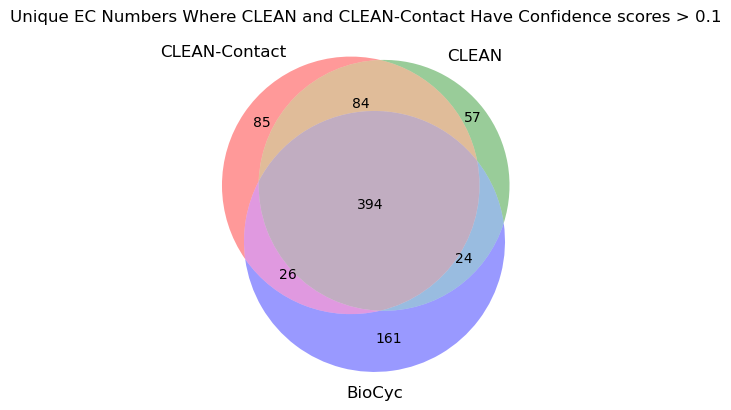

In [35]:
# new venn diagram for all unique ec numbers in the three datasets with cc and clean filtered by confidence
# biocyc numbers haven't changed: 728 rows in the dataframe, 691 rows with an EC number (non-NaN), 605 unique ec numbers
venn3([set(cc_ec_list), set(clean_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title(f'Unique EC Numbers Where CLEAN and CLEAN-Contact Have Confidence scores > {cutoff}') 
plt.show()

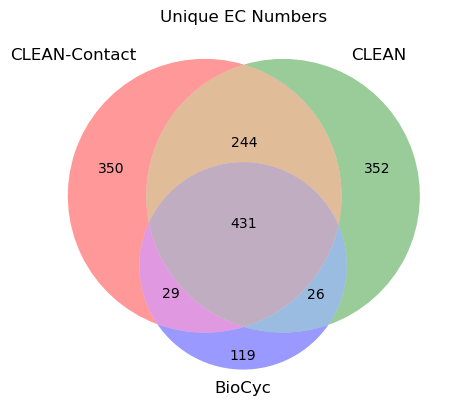

In [36]:
# compare to previous
venn3([set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title('Unique EC Numbers')
plt.show()

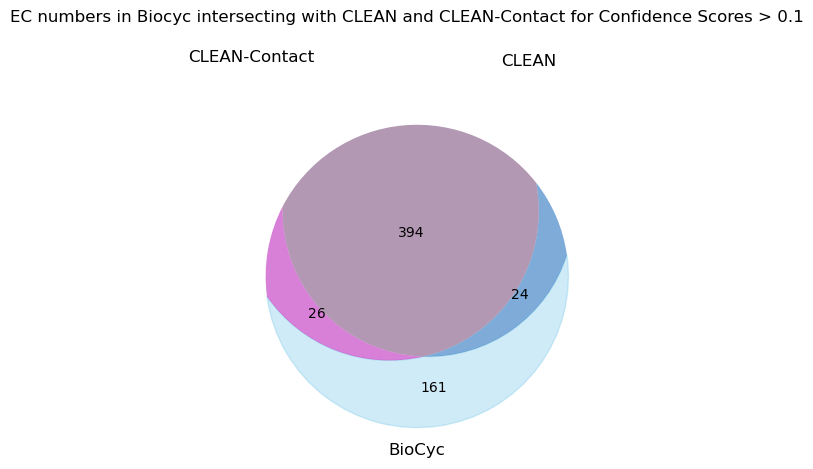

In [37]:
# look at just the purple BioCyc section 
venn = venn3([set(cc_ec_list), set(clean_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))

# Make the patches for Set 2 and Set 3 clear
# comment this part out to keep the other circles
for id_ in ['100', '110', '111', '101', '010']:
    if venn.get_patch_by_id(id_):
        venn.get_patch_by_id(id_).set_alpha(0)

if venn.get_patch_by_id('001'):
    venn.get_patch_by_id('001').set_color('skyblue')
    #venn.get_patch_by_id('001').set_edgecolor('black')

if venn.get_patch_by_id('011'):
    #venn.get_patch_by_id('011').set_edgecolor('black')
    venn.get_patch_by_id('011').set_alpha(0.5)

if venn.get_patch_by_id('101'):
    #venn.get_patch_by_id('101').set_edgecolor('black')
    venn.get_patch_by_id('101').set_alpha(0.5)
    
if venn.get_patch_by_id('111'):
    #venn.get_patch_by_id('111').set_edgecolor('black')
    venn.get_patch_by_id('111').set_alpha(0.5)

for id_ in ['010', '110', '100']:
    if venn.get_label_by_id(id_):
        venn.get_label_by_id(id_).set_text('')
        
# Remove the labels 
#venn.get_label_by_id('A').set_text('')
#venn.get_label_by_id('B').set_text('')

# Add a title
plt.title(f"EC numbers in Biocyc intersecting with CLEAN and CLEAN-Contact for Confidence Scores > {cutoff}")

# Show the plot
plt.tight_layout()
plt.show()

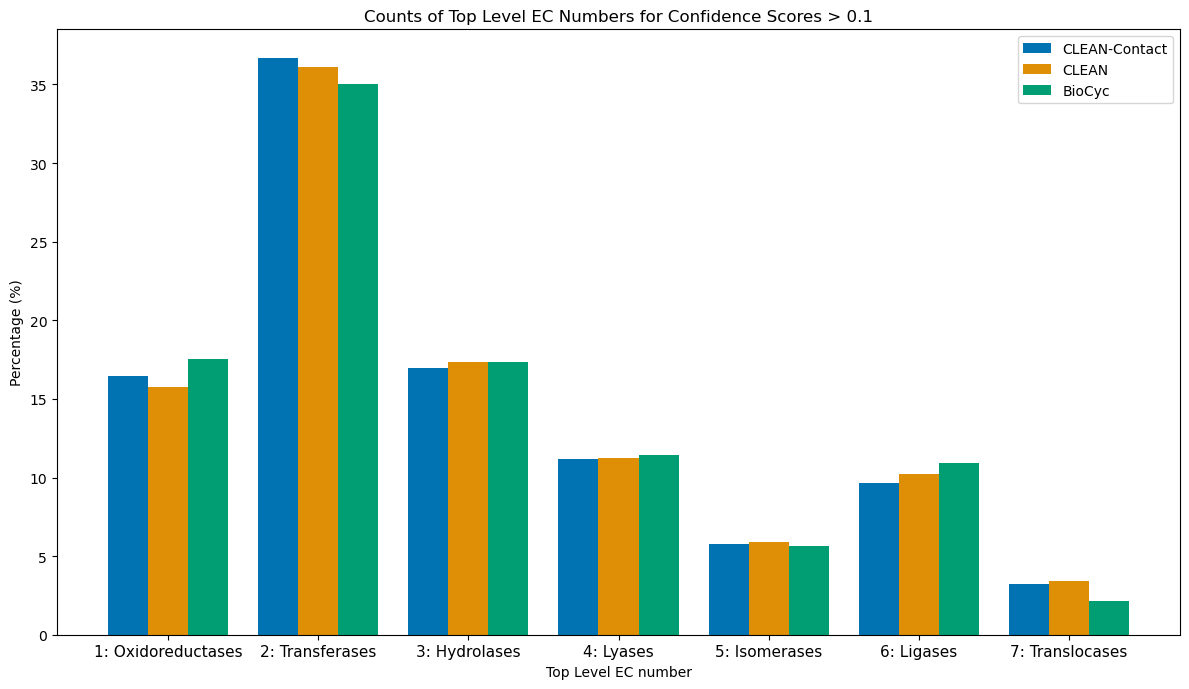

In [38]:
# each input set was unique list of ec numbers in that dataset, and percent is calculated per set 
all_sets = [set(cc_ec_list), set(clean_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, f"Counts of Top Level EC Numbers for Confidence Scores > {cutoff}", 
                                 custom_labels, use_percent=True) 

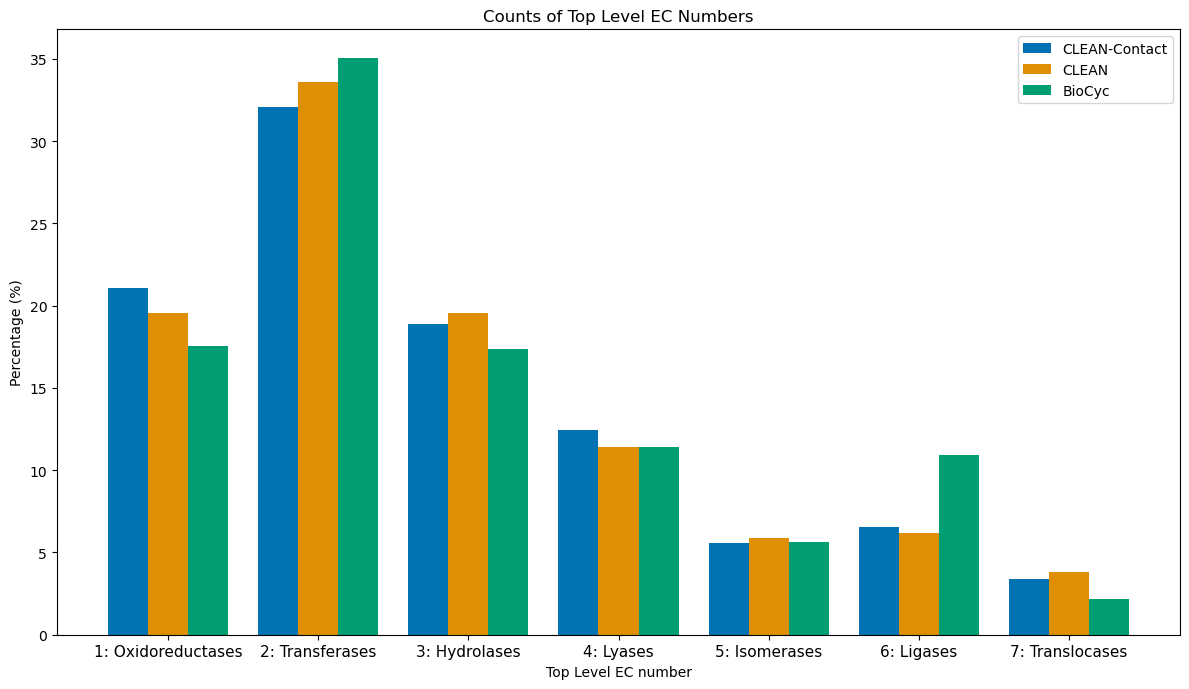

In [39]:
# compare to previous
# each input set was unique list of ec numbers in that dataset, and percent is calculated per set (and per top level) 
# so the blue bar for top level 1 means from the unique ec 
# numbers predicted by cc, around 20% of all those unique ec numbers started with 1
all_sets = [set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers", custom_labels, use_percent=True)
# cc provided proportionately more oxidoreductases, lysases, and ligases than clean

### Is it worth filtering all three datasets so they have the same UniProt IDs? 

could the UniProt ids in the biocyc data somehow add bias to the CLEAN and CLEAN-Contact dataset? idk how biocyc got the uniprot ids that it does have

In [40]:
def contains_n(ec_string):
    # Split the string by commas
    ec_list = ec_string.split(', ')
    # Check if any segment contains 'n'
    return any('n' in ec for ec in ec_list)

In [41]:
# split multiple ec results in one row across multiple rows
columns_to_split = ['BioCyc EC']
biocyc_expanded = separate_results(biocyc, columns_to_split)
biocyc_expanded = biocyc_expanded.dropna(subset=['BioCyc EC'])

# do the datasets have ec numbers with n values?
biocyc_expanded[biocyc_expanded['BioCyc EC'].apply(contains_n)]
# nope. why?

,UniProt,Genes of a reaction from All instances of Reactions in Prochlorococcus marinus pastoris CCMP1986,Matches,Accession-1,Accession-2,Gene products (polypeptides and RNAs only),BioCyc EC


In [58]:
cc_maxsep_expanded[cc_maxsep_expanded['CC maxsep EC'].apply(contains_n)]

,UniProt,Annotation,Sequence,CC maxsep EC,CC maxsep conf,CC maxsep conf SD,CC maxsep cluster dist
138,Q7V0W8,Protein adenylyltransferase SelO OS=Prochloroc...,MSRKSELLKGEETKNFSEFSQLADFSLMNSLNADPHSTKDGNDHRA...,EC:2.7.7.n1,0.7265,0.0761,6.0373
183,Q7V1U3,Large ribosomal subunit assembly factor BipA O...,MSVSIKEIRNVAIIAHVDHGKTTLVDALLSQSGIFRDNEVVPTCVM...,EC:3.6.5.n1,0.9953,0.0018,3.2343
428,Q7UZY6,Elongation factor G OS=Prochlorococcus marinus...,MARDFPLERVRNIGIAAHIDAGKTTTTERILFYSGVVHKIGEVHDG...,EC:3.6.5.n1,0.8147,0.0544,5.8277
584,Q7V228,Peptide chain release factor 3 OS=Prochlorococ...,MSSSTENLNNKNILEAVNKRRNFAIISHPDAGKTTLTEKLLLYGGA...,EC:3.6.5.n1,0.7649,0.0672,5.9541
636,Q7V2Q1,Elongation factor 4 OS=Prochlorococcus marinus...,MTDISVSKIRNFCIIAHIDHGKSTLADRLLQDTGTVKQRDMQDQFL...,EC:3.6.5.n1,0.9964,0.0018,2.3609
921,A8WIF8,Uncharacterized protein OS=Prochlorococcus mar...,MNYSTEQEDYLMTTPYTKKIQKKFKEVKNFLEKNGFNSSSQGLMQD...,EC:2.7.7.n1,0.0193,0.0125,7.7223
1233,Q7UZN5,Single-stranded DNA-binding protein OS=Prochlo...,MEINTINLVGRAGREPDVRYFESGSTVANFTLAVNRISRGDEPDWF...,EC:2.7.7.n1,0.0107,0.0074,7.8944
1372,Q7V091,Putative dape gene and orf2 OS=Prochlorococcus...,MINNINDFKKLNNNDKREKNLNLILDSNSYKLAQEDLNLLRSDEMR...,EC:3.2.2.n1,0.6312,0.0937,6.2133
1508,Q7V0P4,SAM-dependent methyltransferase OS=Prochloroco...,MLINRGKLIYRNIVPKRLRILIRRIFKIFLYKFRFLKFKIILFFAK...,EC:2.1.1.n8,0.0013,0.0011,8.4736
1555,Q7V0U1,2Fe-2S ferredoxin-type domain-containing prote...,MKQSKIKIIWPNNITTIVNEGDDWFSAAEVAGIEIPTGCLTGSCGA...,EC:2.7.7.n1,0.0005,0.0005,8.6917


In [59]:
clean_expanded[clean_expanded['Clean maxsep EC'].apply(contains_n)]

,UniProt,Annotation,Sequence,Clean maxsep EC,Clean maxsep conf,Clean pvalue EC,Clean pvalue cluster dist
138,Q7V0W8,Protein adenylyltransferase SelO OS=Prochloroc...,MSRKSELLKGEETKNFSEFSQLADFSLMNSLNADPHSTKDGNDHRA...,EC:2.7.7.n1,0.9616,EC:2.7.7.n1,4.7597
181,Q7V1U3,Large ribosomal subunit assembly factor BipA O...,MSVSIKEIRNVAIIAHVDHGKTTLVDALLSQSGIFRDNEVVPTCVM...,EC:3.6.5.n1,0.9840,EC:3.6.5.n1,4.3079
439,Q7UZY6,Elongation factor G OS=Prochlorococcus marinus...,MARDFPLERVRNIGIAAHIDAGKTTTTERILFYSGVVHKIGEVHDG...,EC:3.6.5.n1,0.7713,EC:3.6.5.n1,5.6010
505,Q7V0U6,Photosystem I assembly protein Ycf4 OS=Prochlo...,MQSNLSSFNKIEQKINGSRKISNYLIGGMLSIGGIGFILAAISSYT...,EC:1.2.1.n2,0.0000,"EC:1.2.1.n2, EC:2.4.2.46","9.2027, 9.2642"
598,Q7V228,Peptide chain release factor 3 OS=Prochlorococ...,MSSSTENLNNKNILEAVNKRRNFAIISHPDAGKTTLTEKLLLYGGA...,EC:3.6.5.n1,0.0100,EC:3.6.5.n1,7.5463
649,Q7V2Q1,Elongation factor 4 OS=Prochlorococcus marinus...,MTDISVSKIRNFCIIAHIDHGKSTLADRLLQDTGTVKQRDMQDQFL...,EC:3.6.5.n1,0.9989,EC:3.6.5.n1,1.6035
1157,Q7TUB9,Possible Elongation factor Tu domain 2 OS=Proc...,MNNATPDFLFIRPSGNPISAKGFEEMMNSGDVVQEKAEITKIHRFE...,EC:3.2.1.n1,0.0000,EC:3.2.1.n1,10.5176
1248,Q7UZM5,Aspartyl protease OS=Prochlorococcus marinus s...,MIKNVIKNICLIGFALIGPITLPAGGIQRDLNKYNTLNNSKEIILN...,EC:4.2.2.n1,0.0000,EC:3.1.31.1,9.7256
1538,Q7V0R2,Uncharacterized protein OS=Prochlorococcus mar...,MPLRLKNLVFNVTFNSCLFLILIIGIQNSSKKSSINLLIDETVNLP...,EC:2.3.1.n7,0.0000,EC:2.3.1.n7,9.3882
1594,Q7V0Y0,PH domain-containing protein OS=Prochlorococcu...,MVEKFKTLFFVKSSLISLYLALTCPIPFISSEKLKIFSIITFFFGL...,EC:2.3.1.n4,0.0003,EC:2.3.1.n4,8.5534


In [42]:
# rows need both a uniprot id and an ec number
# biocyc_subset was already exapnded, but is a subset since the rows with NaNs in 'UniProt' or 'BioCyc EC' are removed
biocyc_subset = biocyc_expanded.copy()
biocyc_subset = biocyc_subset.dropna(subset=['UniProt', 'BioCyc EC'])
biocyc_subset

,UniProt,Genes of a reaction from All instances of Reactions in Prochlorococcus marinus pastoris CCMP1986,Matches,Accession-1,Accession-2,Gene products (polypeptides and RNAs only),BioCyc EC
0,Q7V2E7,aarA,octadecanal + acyl-carrier protein + NAD(P)+ ...,PMM0533,TX50_RS02855,long-chain acyl-[acyl-carrier-protein] reductase,EC:1.2.1.80
1,Q7V2E6,accA,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0534,TX50_RS02860,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
2,Q7TUH9,accB,ATP + acetyl-CoA + hydrogencarbonate -> ADP ...,PMM0027,TX50_RS00150,acetyl-CoA carboxylase biotin carboxyl carrier...,EC:6.4.1.2
3,Q7V3L5,accC,a [biotin carboxyl-carrier-protein dimer]-N6-b...,PMM0060,TX50_RS00320,acetyl-CoA carboxylase biotin carboxylase subunit,EC:6.3.4.14
4,Q7V1S1,accD,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0784,TX50_RS04185,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
...,...,...,...,...,...,...,...
926,Q7TUC1,vnfG,12 reduced ferredoxin [iron-sulfur] cluster + ...,PMM0657,TX50_RS03490,possible Vanadium/alternative nitrogenase delt...,EC:1.18.6.2
927,Q7V2J2,xth,[DNA]-3'-hydroxyl + H2O -> a [DNAn-1]-3'-hyd...,PMM0484,TX50_RS02610,exodeoxyribonuclease III,EC:3.1.11.2
930,Q7V0W4,ychF,ATP + H2O -> ADP + phosphate + H+,PMM1138,TX50_RS06135,redox-regulated ATPase YchF,EC:3.6.1.15
931,Q7V3G0,zds,beta-zeacarotene + an electron-transfer quinon...,PMM0115,TX50_RS00605,"9,9'-di-cis-zeta-carotene desaturase",EC:1.3.5.6


In [43]:
# find common uniprot ids
biocyc_subset_uniprot = set(biocyc_subset['UniProt'])
print(len(biocyc_subset_uniprot))
cc_uniprot = set(cc_maxsep['UniProt'])
print(len(cc_uniprot))
clean_uniprot = set(clean_results['UniProt'])
print(len(clean_uniprot))

common_uniprot = list(biocyc_subset_uniprot & cc_uniprot & clean_uniprot)
print(len(common_uniprot))

684
1939
1942
682


In [44]:
# filter for the common uniprot ids
biocyc_uniprot = biocyc_subset.copy()
biocyc_uniprot = biocyc_uniprot[biocyc_uniprot['UniProt'].isin(common_uniprot)]
biocyc_uniprot

,UniProt,Genes of a reaction from All instances of Reactions in Prochlorococcus marinus pastoris CCMP1986,Matches,Accession-1,Accession-2,Gene products (polypeptides and RNAs only),BioCyc EC
0,Q7V2E7,aarA,octadecanal + acyl-carrier protein + NAD(P)+ ...,PMM0533,TX50_RS02855,long-chain acyl-[acyl-carrier-protein] reductase,EC:1.2.1.80
1,Q7V2E6,accA,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0534,TX50_RS02860,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
2,Q7TUH9,accB,ATP + acetyl-CoA + hydrogencarbonate -> ADP ...,PMM0027,TX50_RS00150,acetyl-CoA carboxylase biotin carboxyl carrier...,EC:6.4.1.2
3,Q7V3L5,accC,a [biotin carboxyl-carrier-protein dimer]-N6-b...,PMM0060,TX50_RS00320,acetyl-CoA carboxylase biotin carboxylase subunit,EC:6.3.4.14
4,Q7V1S1,accD,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0784,TX50_RS04185,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
...,...,...,...,...,...,...,...
926,Q7TUC1,vnfG,12 reduced ferredoxin [iron-sulfur] cluster + ...,PMM0657,TX50_RS03490,possible Vanadium/alternative nitrogenase delt...,EC:1.18.6.2
927,Q7V2J2,xth,[DNA]-3'-hydroxyl + H2O -> a [DNAn-1]-3'-hyd...,PMM0484,TX50_RS02610,exodeoxyribonuclease III,EC:3.1.11.2
930,Q7V0W4,ychF,ATP + H2O -> ADP + phosphate + H+,PMM1138,TX50_RS06135,redox-regulated ATPase YchF,EC:3.6.1.15
931,Q7V3G0,zds,beta-zeacarotene + an electron-transfer quinon...,PMM0115,TX50_RS00605,"9,9'-di-cis-zeta-carotene desaturase",EC:1.3.5.6


In [45]:
cc_uniprot = cc_maxsep_expanded.copy()
cc_uniprot = cc_uniprot[cc_uniprot['UniProt'].isin(common_uniprot)]
cc_uniprot

,UniProt,Annotation,Sequence,CC maxsep EC,CC maxsep conf,CC maxsep conf SD,CC maxsep cluster dist
0,Q7TU21,Aspartate-semialdehyde dehydrogenase OS=Prochl...,MRNSPFLPNRPLKVAVLGSSGAVGSELLKILEERDFPISELVLLSS...,EC:1.2.1.11,0.9863,0.0041,4.3332
1,Q7UZH7,CTP synthase OS=Prochlorococcus marinus subsp....,MSKFVFVTGGVVSSIGKGIVAASLGRLLKSRGYSVSILKLDPYLNV...,EC:6.3.4.2,0.9961,0.0017,2.8527
2,Q7UZR6,Bifunctional pantoate ligase/cytidylate kinase...,MNKIIIRKTEDLKEWRRNLKCDINFIPTMGNLHDGHQKLISTAQSS...,EC:6.3.2.1,0.8120,0.0551,5.8351
3,Q7V010,Probable dual-specificity RNA methyltransferas...,MKNLLGCSVKDLEKIALNYGQAAFRGRQIYNWLYNYKNRSKSIDEI...,EC:2.1.1.192,0.9923,0.0025,3.8433
5,Q7V0G1,UDP-N-acetylglucosamine 1-carboxyvinyltransfer...,MVCVSNNKSYLKSQHLKIIGQKTLRGKVKISGAKNSALVLLAASLL...,EC:2.5.1.7,0.9539,0.0135,5.0980
...,...,...,...,...,...,...,...
2309,Q7V3N9,Soluble hydrogenase small subunit OS=Prochloro...,MAIQQKLSLMIPGPTPVPEKVLQALGRHPIGHRSKDFQDLMEITTK...,EC:2.6.1.45,0.1997,0.0782,6.9230
2315,Q7V3P4,Putative pyridoxal phosphate biosynthetic prot...,MNNQSNDNEDKFKIIISVGDESGIGPEIILKALFSKEIPYNLDFII...,EC:1.1.1.262,0.5610,0.1022,6.3273
2316,Q7V3P6,peptidylprolyl isomerase OS=Prochlorococcus ma...,MQNFLSNQNKHFLFLILILIHVCLLKPTQVFADLPTGNAVKDPNAI...,EC:5.2.1.8,0.1016,0.0491,7.1867
2319,Q7V3Q5,peptide-methionine (R)-S-oxide reductase OS=Pr...,MNQFFSRRSFILIPIMSILKFILQPKKVLAAFAASDDDWNLSKEDW...,EC:1.8.4.12,0.9476,0.0154,5.1693


In [46]:
clean_uniprot = clean_expanded.copy()
clean_uniprot = clean_uniprot[clean_uniprot['UniProt'].isin(common_uniprot)]
clean_uniprot

,UniProt,Annotation,Sequence,Clean maxsep EC,Clean maxsep conf,Clean pvalue EC,Clean pvalue cluster dist
0,Q7TU21,Aspartate-semialdehyde dehydrogenase OS=Prochl...,MRNSPFLPNRPLKVAVLGSSGAVGSELLKILEERDFPISELVLLSS...,EC:1.2.1.11,0.9935,EC:1.2.1.11,3.7585
1,Q7UZH7,CTP synthase OS=Prochlorococcus marinus subsp....,MSKFVFVTGGVVSSIGKGIVAASLGRLLKSRGYSVSILKLDPYLNV...,EC:6.3.4.2,0.9976,EC:6.3.4.2,2.9574
2,Q7UZR6,Bifunctional pantoate ligase/cytidylate kinase...,MNKIIIRKTEDLKEWRRNLKCDINFIPTMGNLHDGHQKLISTAQSS...,EC:2.7.4.25,0.2534,EC:2.7.4.25,6.4352
3,Q7V010,Probable dual-specificity RNA methyltransferas...,MKNLLGCSVKDLEKIALNYGQAAFRGRQIYNWLYNYKNRSKSIDEI...,EC:2.1.1.192,0.9917,"EC:2.1.1.192, EC:2.1.1.224","3.9242, 4.9630"
5,Q7V0G1,UDP-N-acetylglucosamine 1-carboxyvinyltransfer...,MVCVSNNKSYLKSQHLKIIGQKTLRGKVKISGAKNSALVLLAASLL...,EC:2.5.1.7,0.9925,EC:2.5.1.7,3.8519
...,...,...,...,...,...,...,...
2325,Q7V3N9,Soluble hydrogenase small subunit OS=Prochloro...,MAIQQKLSLMIPGPTPVPEKVLQALGRHPIGHRSKDFQDLMEITTK...,EC:2.6.1.44,0.2048,EC:2.6.1.51,6.3385
2330,Q7V3P4,Putative pyridoxal phosphate biosynthetic prot...,MNNQSNDNEDKFKIIISVGDESGIGPEIILKALFSKEIPYNLDFII...,EC:1.1.1.262,0.9815,EC:1.1.1.262,4.3859
2331,Q7V3P6,peptidylprolyl isomerase OS=Prochlorococcus ma...,MQNFLSNQNKHFLFLILILIHVCLLKPTQVFADLPTGNAVKDPNAI...,EC:5.2.1.8,0.0245,EC:5.2.1.8,7.2752
2333,Q7V3Q5,peptide-methionine (R)-S-oxide reductase OS=Pr...,MNQFFSRRSFILIPIMSILKFILQPKKVLAAFAASDDDWNLSKEDW...,EC:1.8.4.12,0.9948,"EC:1.8.4.12, EC:1.8.4.14","3.6049, 4.9037"


In [47]:
#sanity check 
print(len(biocyc_uniprot['UniProt'].unique()))
print(len(cc_uniprot['UniProt'].unique()))
print(len(clean_uniprot['UniProt'].unique()))

682
682
682


run the confidence visuals again, now on datasets with same uniprot ids

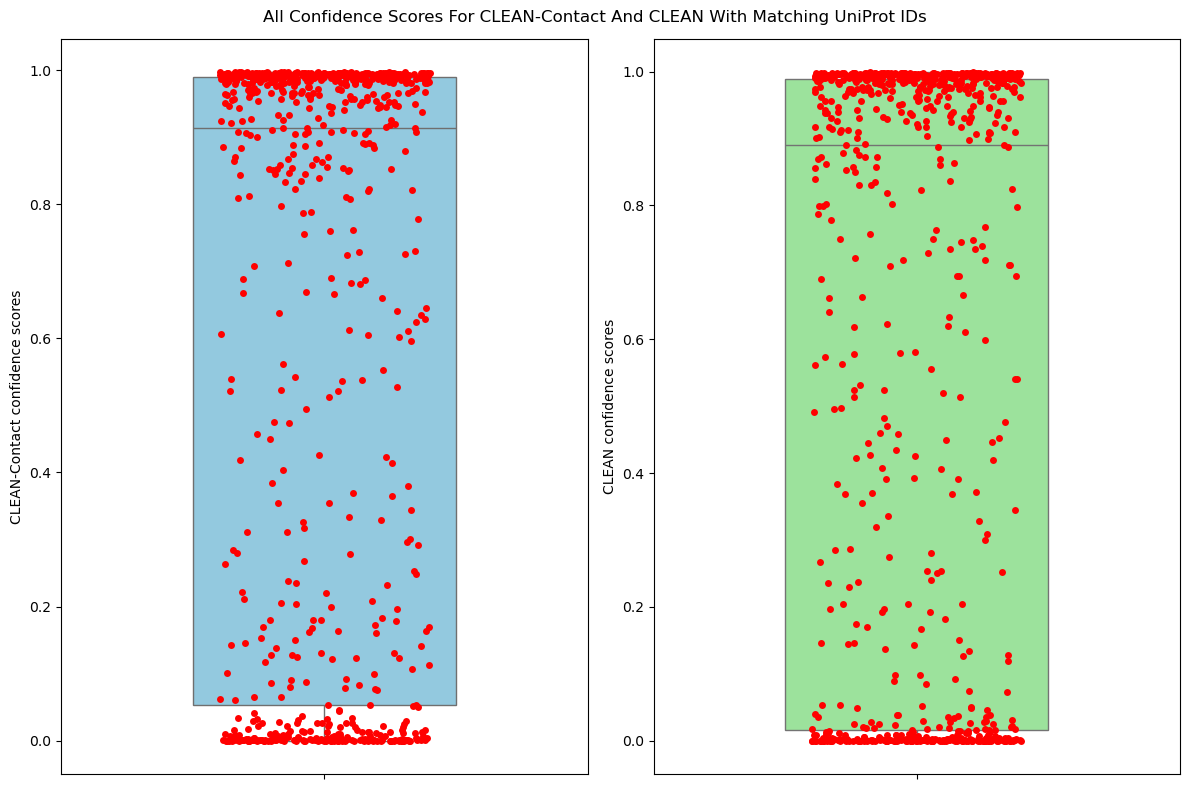

In [48]:
# comment out the 2 sns.stripplot() lines to view the boxplots without the red dots
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

sns.boxplot(data=cc_uniprot, y='CC maxsep conf', ax=axs[0], color='skyblue', width=.5)
sns.stripplot(data=cc_uniprot, y='CC maxsep conf', ax=axs[0], color='red', jitter=0.2)
axs[0].set_ylabel('CLEAN-Contact confidence scores')

sns.boxplot(data=clean_uniprot, y='Clean maxsep conf', ax=axs[1], color='lightgreen', width=.5)
sns.stripplot(data=clean_uniprot, y='Clean maxsep conf', ax=axs[1], color='red', jitter=0.2)
axs[1].set_ylabel('CLEAN confidence scores')

fig.suptitle('All Confidence Scores For CLEAN-Contact And CLEAN With Matching UniProt IDs')

plt.tight_layout()
plt.show()

In [49]:
# look at the summary stats 
print("CLEAN-Contact confidence scores summary")
print(cc_uniprot['CC maxsep conf'].describe(), "\n")

print("CLEAN confidence scores summary")
print(clean_uniprot['Clean maxsep conf'].describe())

CLEAN-Contact confidence scores summary
count    773.000000
mean       0.621939
std        0.429954
min        0.000000
25%        0.053700
50%        0.913100
75%        0.989200
max        0.996400
Name: CC maxsep conf, dtype: float64 

CLEAN confidence scores summary
count    782.000000
mean       0.594569
std        0.438335
min        0.000000
25%        0.016625
50%        0.891100
75%        0.989800
max        0.998900
Name: Clean maxsep conf, dtype: float64


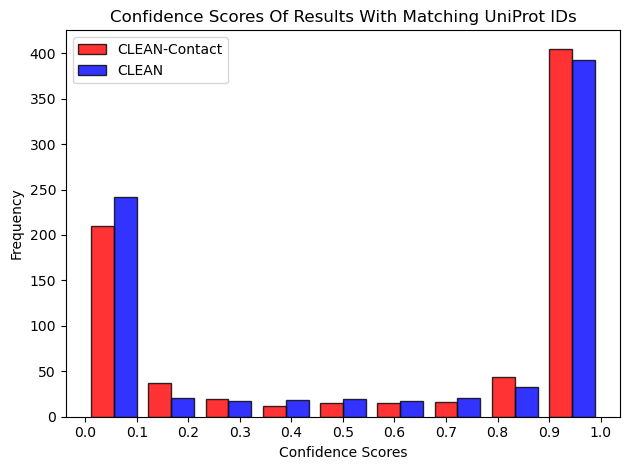

Chi-Square Statistic: 11.205517364326383
P-Value: 0.19032401729090007
The datasets do not have a statistically significant difference for the bins (p > 0.05).


In [50]:
bins = np.linspace(0, 1, 10) 
plt.hist([cc_uniprot['CC maxsep conf'], clean_uniprot['Clean maxsep conf']],
          bins=bins, color=['r', 'b'], alpha=0.8, label=['CLEAN-Contact', 'CLEAN'], edgecolor='black')

plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title("Confidence Scores Of Results With Matching UniProt IDs")

plt.legend(loc='upper left')
x_ticks = np.arange(0, 1.01, 0.1)
plt.xticks(x_ticks)
plt.tight_layout()
plt.show()

# perform Chi-Square test even though I'm not 100% sure its helpful here? remove everything in this cell below if this
# test is not worth reporting
# calculate histogram counts 
cc_counts, _ = np.histogram(cc_uniprot['CC maxsep conf'], bins=bins)
clean_counts, _ = np.histogram(clean_uniprot['Clean maxsep conf'], bins=bins)

# apply continuity correction by adding a small value to all counts if one bin has 0 counts in it
#cc_counts += .1
#clean_counts += .1

# use chi2_contingency not chisquare since there's not an expected distribution and observed; we're 
# comparing two different datasets to test if their distribution is the same
chi2_stat, p_val, dof, ex = chi2_contingency([cc_counts, clean_counts])

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# determine statistical significance
alpha = 0.05  
if p_val <= alpha:
    print("The datasets have a statistically significant difference for the bins (p <= 0.05).")
else:
    print("The datasets do not have a statistically significant difference for the bins (p > 0.05).")

try to find confidence score threshold for the datasets with the same uniprot ids

In [51]:
cutoff = 0.1
#cutoff = 0.8

cc_uniprot_filtered = cc_uniprot[cc_uniprot['CC maxsep conf'] > cutoff]
print("CLEAN-Contact filtered dataframe shape:", cc_uniprot_filtered.shape)
clean_uniprot_filtered = clean_uniprot[clean_uniprot['Clean maxsep conf'] > cutoff]
print("CLEAN filtered dataframe shape:", clean_uniprot_filtered.shape)

CLEAN-Contact filtered dataframe shape: (566, 7)
CLEAN filtered dataframe shape: (540, 7)


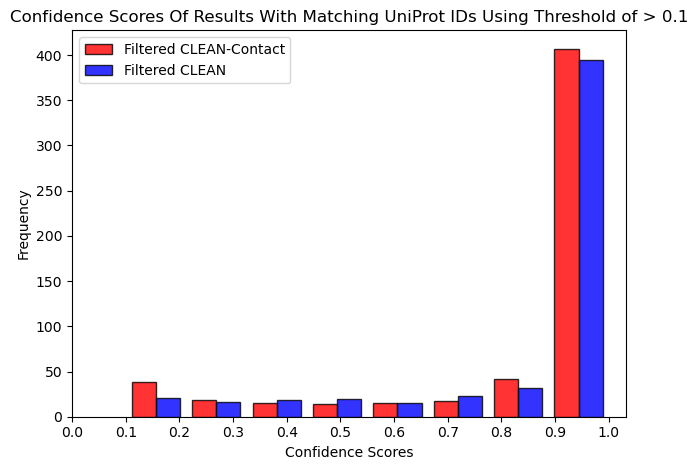

Chi-Square Statistic: 8.401132692732983
P-Value: 0.2985539705057727
The datasets do not have a statistically significant difference for the bins (p > 0.05).


In [52]:
bins = np.linspace(0.1, 1, 9) # keep this as bins for cutoff of 0.1
#bins = np.linspace(0.8, 1, 2)
plt.hist([cc_uniprot_filtered['CC maxsep conf'], clean_uniprot_filtered['Clean maxsep conf']],
          bins=bins, color=['r', 'b'], alpha=0.8, label=['Filtered CLEAN-Contact', 'Filtered CLEAN'], edgecolor='black')

plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title(f'Confidence Scores Of Results With Matching UniProt IDs Using Threshold of > {cutoff}')

plt.legend(loc='upper left')
x_ticks = np.arange(0, 1.01, 0.1)
plt.xticks(x_ticks)
plt.tight_layout()
plt.show()

# calculate histogram counts 
cc_counts, _ = np.histogram(cc_uniprot_filtered['CC maxsep conf'], bins=bins)
clean_counts, _ = np.histogram(clean_uniprot_filtered['Clean maxsep conf'], bins=bins)

# apply continuity correction by adding a small value to all counts if one bin has 0 counts in it
#cc_counts += .1
#clean_counts += .1

# perform Chi-Square test even though I'm not 100% sure its helpful here?
# use chi2_contingency not chisquare since there's not an expected distribution and observed; we're 
# comparing two different datasets to test if their distribution is the same
chi2_stat, p_val, dof, ex = chi2_contingency([cc_counts, clean_counts])

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# determine statistical significance
alpha = 0.05  
if p_val <= alpha:
    print("The datasets have a statistically significant difference for the bins (p <= 0.05).")
else:
    print("The datasets do not have a statistically significant difference for the bins (p > 0.05).")

In [53]:
cc_uniprot_filtered_ec = list_of_unique_ecs(cc_uniprot_filtered, 'CC maxsep EC')
print("unique number of ec numbers in the filtered CLEAN-Contact dataset:", len(cc_uniprot_filtered_ec)) 
clean_uniprot_filtered_ec = list_of_unique_ecs(clean_uniprot_filtered, 'Clean maxsep EC')
print("unique number of ec numbers in the filtered CLEAN dataset:", len(clean_uniprot_filtered_ec)) 
biocyc_uniprot_ec = list_of_unique_ecs(biocyc_uniprot, "BioCyc EC")
print("unique number of ec numbers in the BioCyc dataset:", len(biocyc_uniprot_ec )) 

unique number of ec numbers in the filtered CLEAN-Contact dataset: 476
unique number of ec numbers in the filtered CLEAN dataset: 463
unique number of ec numbers in the BioCyc dataset: 602


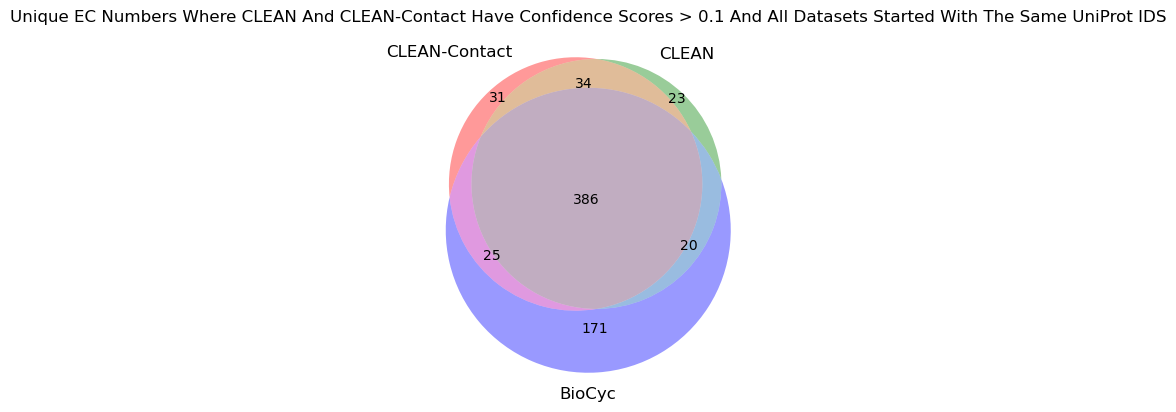

In [54]:
venn3([set(cc_uniprot_filtered_ec), set(clean_uniprot_filtered_ec), set(biocyc_uniprot_ec)], 
      ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title(f'Unique EC Numbers Where CLEAN And CLEAN-Contact Have Confidence Scores > {cutoff} And All Datasets Started With The Same UniProt IDS') 
plt.show()

unique number of ec numbers in the CLEAN-Contact dataset: 586
unique number of ec numbers in the CLEAN dataset: 599


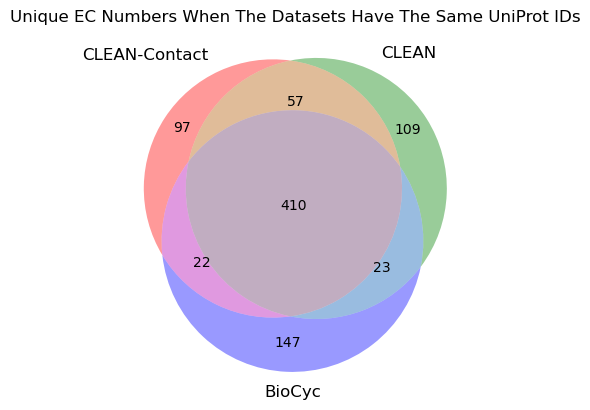

In [55]:
# not filtered by confidence score
cc_uniprot_ec = list_of_unique_ecs(cc_uniprot, 'CC maxsep EC')
print("unique number of ec numbers in the CLEAN-Contact dataset:", len(cc_uniprot_ec)) 
clean_uniprot_ec = list_of_unique_ecs(clean_uniprot, 'Clean maxsep EC')
print("unique number of ec numbers in the CLEAN dataset:", len(clean_uniprot_ec)) 
# before filtering confidence scores
venn3([set(cc_uniprot_ec), set(clean_uniprot_ec), set(biocyc_uniprot_ec)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title('Unique EC Numbers When The Datasets Have The Same UniProt IDs')
plt.show()

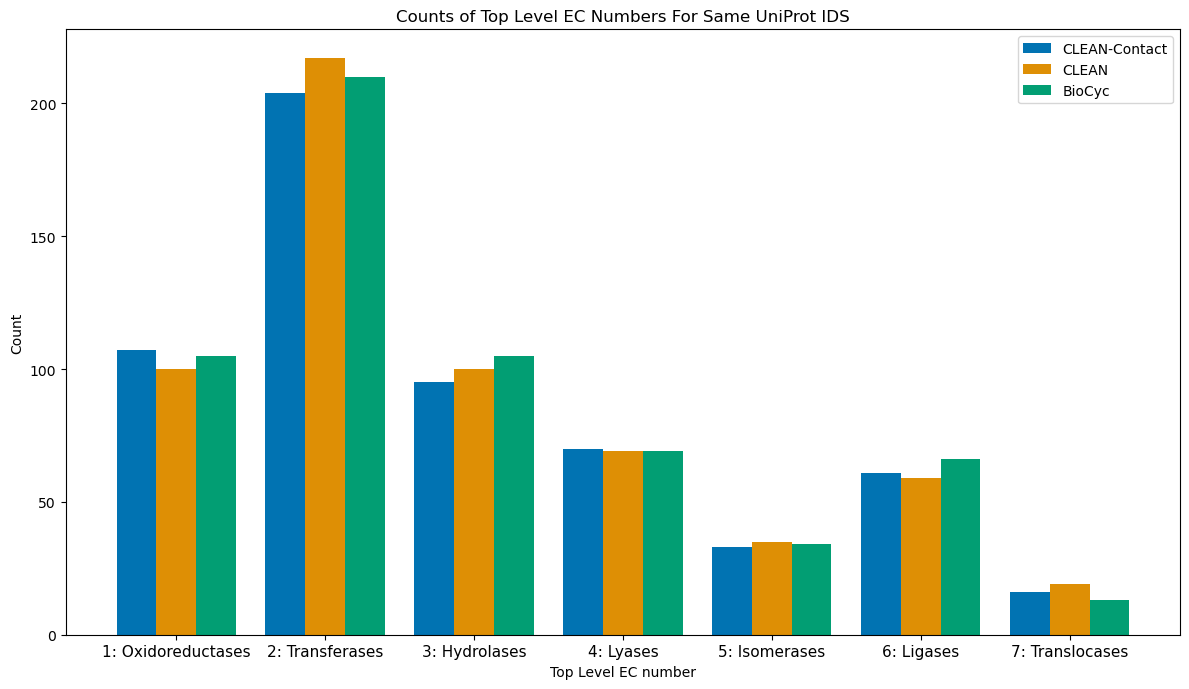

In [56]:
all_sets = [set(cc_uniprot_ec), set(clean_uniprot_ec), set(biocyc_uniprot_ec)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers For Same UniProt IDS", custom_labels)

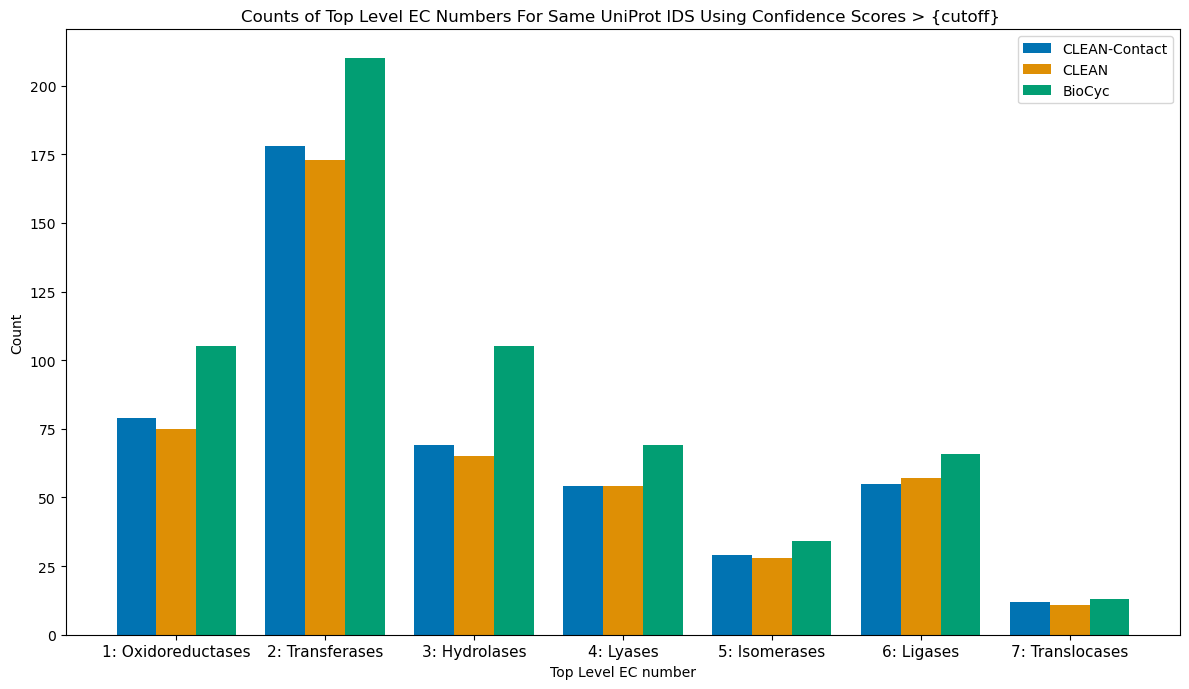

In [57]:
# when clean and clean-contact are filtered by the confidence score, and all 3 datasets started with the same uniprot ids
all_sets = [set(cc_uniprot_filtered_ec), set(clean_uniprot_filtered_ec), set(biocyc_uniprot_ec)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers For Same UniProt IDS Using Confidence Scores > {cutoff} ", custom_labels)